In [1]:
import numpy as np 
import pandas as pd
from collections import Counter
from pandasql import sqldf
import re
import os 
os.environ['CUDA_VISIBLE_DEVICES']='0'
import joblib
import json 
import jieba 
import copy

from openai import AzureOpenAI
import matplotlib.pyplot as plt 
from sentence_transformers import SentenceTransformer
from FlagEmbedding import FlagReranker
from transformers import AutoTokenizer
from sklearn.metrics import average_precision_score

In [2]:
# pandasql查询函数需要的环境
pysqldf = lambda q: sqldf(q, globals())

In [3]:
# 原始数据处理
def format_model(x):
    model_list = x.split(',')
    model_list = [i.strip().lower() for i in model_list]
    new_list = [model_list[0]]
    i = 1
    while i < len(model_list):
        if (i != len(model_list) - 1) and (model_list[i-1] == model_list[i]):
            new_list.append(model_list[i]+model_list[i+1])
            if i < len(model_list) - 1:
                i += 2
            else:
                break
        elif (i != len(model_list) - 1) and (model_list[i-1] != model_list[i]):
            new_list.append(model_list[i])
            i += 1
        elif (model_list[i] == "上下水") or (model_list[i] == "air"):
            for j in range(len(new_list)):
                if model_list[i-1] == new_list[j]:
                    new_list.pop(j)
                    break
            new_list.append(model_list[i-1]+model_list[i])
            i += 1
        else:
            new_list.append(model_list[i])
            break
    return new_list

def format_all_models(x, dim_df):
    new_list = []
    for i in x:
        if i.find("全型号") >= 0:
            end_idx = i.find("全型号")
            name = i[:end_idx]
            new_list += [j for j in dim_df[dim_df['cat_name'] == name].model.tolist() if j not in x]
        else:
            new_list.append(i)
    return new_list

def format_series(x, dim_df):
    def contains_chinese(s):
        return re.search('[\u4e00-\u9fff]', s) is not None
    new_list = []
    for i in x:
        if i.find("系列") >= 0:
            end_idx = i.find("系列")
            name = i[:end_idx]
            new_list += [j for j in dim_df[(dim_df.model.str.find(name)>=0) & (
                dim_df.model.apply(lambda x: not contains_chinese(x)))].model.tolist() if j not in x]
            new_list += [i]
        else:
            new_list.append(i)
    return new_list

In [4]:
# 拼接openai embedding
def generate_embeddings(text, model="text-embedding-ada-002"): # model = "deployment_name"
    return client.embeddings.create(input=[text], model=model).data[0].embedding

In [5]:
# 测试集处理及计算与正确qa的相似度
def cosine_similarity(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

def search_docs(df, user_query, top_n=4, to_print=True):
    embedding = generate_embeddings(
        user_query,
    )
    df["similarities"] = df.ada_002.apply(lambda x: cosine_similarity(x, embedding))

    res = (
        df.sort_values("similarities", ascending=False)
        .head(top_n)
    )[["qa_id", "question", "answer", "similarities"]]
    return res.to_dict(orient='records')

def concat(x):
    return ",".join(x.astype(str).tolist())

def format_gt(x):
    if str(x) == "nan":
        return x
    else:
        return ",".join(x.split("\n"))

def count_gt(x):
    if str(x) == "nan":
        return 0
    else:
        return len(x.split(","))   

In [6]:
# 向量召回
def search_docs_bge(df, user_query, top_n=4, to_print=True):
    embedding = model.encode(user_query, normalize_embeddings=True).tolist()
    df["similarities"] = df.bge_large.apply(lambda x: cosine_similarity(x, embedding))
    output_columns = ["qa_id", "question", "answer", "similarities"]
    if "hit_reason" in df.columns:
        output_columns.append("hit_reason")
    res = (
        df.sort_values("similarities", ascending=False)
        .head(top_n)
    )[output_columns]
    return res.to_dict(orient='records')

def find_non_chinese_substrings(s):
    # 正则表达式解释：
    # [^\u4e00-\u9fff\W]+ 匹配非中文字符和非ASCII标点的连续字符
    # 但这样会排除空格，所以我们需要允许空格存在
    # 我们使用(?:[^\u4e00-\u9fff\W]| )+ 来实现这一点，(?:) 是非捕获组，用于匹配模式但不作为捕获结果返回
    # [^\u4e00-\u9fff\W] 匹配非中文且非标点的字符，| 表示或，空格 ' ' 被显式允许
    pattern = r'(?:[^\u4e00-\u9fff\W]| )+'
    
    # 使用findall方法查找所有匹配项
    matches = re.findall(pattern, s)
    
    # 过滤掉只包含空格的字符串
    matches = [match for match in matches if not match.isspace()]
    
    return matches

def clean_string(s):
    s = s.replace(" ", "").lower()
    return s

def find_model(x, all_model_list):
    x = x.replace("\n", "") 
    x = find_non_chinese_substrings(x)
    result = [clean_string(s) for s in x]
    return [model for model in all_model_list if model in result]

def find_cat(x, all_cat_list):
    return [name for name in all_cat_list if name in x]   

def filter_model(x, model_list):
    x = x.split(",")
    for model in model_list:
        if model in x:
            return True
    return False

def find_error_with_reason(a):
    # 第一次匹配“错误xxx”
    pattern1 = r"错误\s*\d+"
    matches1 = re.findall(pattern1, a)
    
    # 第二次匹配“错误原因xxx”
    pattern2 = r"错误原因\s*\d+"
    matches2 = re.findall(pattern2, a)

    # 合并两次匹配的结果
    matches = matches1 + matches2
    
    return [name.replace(" ", "").replace("原因", "") for name in matches]

def filter_reason(x, query_reason_list):
    reason_list = find_error_with_reason(x)
    for name in query_reason_list:
        if name in reason_list:
            return True 
    return False

def transform_model_name(x, all_model_list):
    x = x.replace("\n", "") 
    candidates = find_non_chinese_substrings(x)
    for name in candidates:
        cleaned_name = clean_string(name)
        for model in all_model_list:
            if cleaned_name == model:
                x = x.replace(name, model)
                break
    return x 

def remove_model_name(x, all_model_list):
    x = x.replace("\n", "") 
    candidates = find_non_chinese_substrings(x)
    for name in candidates:
        if clean_string(name) in all_model_list:
            x = x.replace(name, "")
    return x 

class BM25_Model(object):
    def __init__(self, documents_list, k1=2, k2=1, b=0.5):
        self.documents_list = documents_list
        self.documents_number = len(documents_list)
        self.avg_documents_len = sum([len(document) for document in documents_list]) / self.documents_number
        self.f = []
        self.idf = {}
        self.k1 = k1
        self.k2 = k2
        self.b = b
        self.init()

    def init(self):
        df = {}
        for document in self.documents_list:
            temp = {}
            for word in document:
                temp[word] = temp.get(word, 0) + 1
            self.f.append(temp)
            for key in temp.keys():
                df[key] = df.get(key, 0) + 1
        for key, value in df.items():
            self.idf[key] = np.log((self.documents_number - value + 0.5) / (value + 0.5))

    def get_score(self, index, query):
        score = 0.0
        document_len = len(self.f[index])
        qf = Counter(query)
        for q in query:
            if q not in self.f[index]:
                continue
            score += self.idf[q] * (self.f[index][q] * (self.k1 + 1) / (
                        self.f[index][q] + self.k1 * (1 - self.b + self.b * document_len / self.avg_documents_len))) * (
                                 qf[q] * (self.k2 + 1) / (qf[q] + self.k2))

        return score

    def get_documents_score(self, query, indices):
        score_list = []
        for i in indices:
            score_list.append(self.get_score(i, query))
        return score_list


class WordCut:
    def __init__(self, all_model_list=None):
        with open('/data/dataset/kefu/hit_stopwords.txt', encoding='utf-8') as f: # 可根据需要打开停用词库，然后加上不想显示的词语
            con = f.readlines()
            stop_words = set()
            for i in con:
                i = i.replace("\n", "")   # 去掉读取每一行数据的\n
                stop_words.add(i)
        self.stop_words = stop_words
        self.all_model_list = all_model_list
        
    def cut(self, mytext):
        # jieba.load_userdict('自定义词典.txt')  # 这里你可以添加jieba库识别不了的网络新词，避免将一些新词拆开
        # jieba.initialize()  # 初始化jieba
        # 文本预处理 ：去除一些无用的字符只提取出中文出来
        # new_data = re.findall('[\u4e00-\u9fa5]+', mytext, re.S)
        # new_data = " ".join(new_data)
        # 匹配中英文标点符号，以及全角和半角符号
        pattern = r'[\u3000-\u303f\uff01-\uff0f\uff1a-\uff20\uff3b-\uff40\uff5b-\uff65\u2018\u2019\u201c\u201d\u2026\u00a0\u2022\u2013\u2014\u2010\u2027\uFE10-\uFE1F\u3001-\u301E]|[\.,!¡?¿\-—_(){}[\]\'\";:/]'
        # 使用 re.sub 替换掉符合模式的字符为空字符
        new_data = re.sub(pattern, '', mytext)
        new_data = transform_model_name(new_data, self.all_model_list)
        # 文本分词
        seg_list_exact = jieba.lcut(new_data)
        result_list = []
        # 去除停用词并且去除单字
        for word in seg_list_exact:
            if word not in self.stop_words and len(word) > 1:
                result_list.append(word) 
        return result_list

def search_docs_bm25(df, indices, user_query, top_n=4):
    # document_list = [wc.cut(doc) for doc in df.question]
    # bm25_model = BM25_Model(document_list)
    embedding = wc.cut(user_query)
    df["similarities"] = bm25_model.get_documents_score(embedding, indices)
    output_columns = ["qa_id", "question", "answer", "similarities"]
    if "hit_reason" in df.columns:
        output_columns.append("hit_reason")
    res = (
        df.sort_values("similarities", ascending=False)
        .head(top_n)
    )[output_columns]
    return res.to_dict(orient='records')

In [7]:
# 综合分析
def ranking_metric(x):
    if (x.find("error")>=0) and (x.find("model")>=0):
        return 1 
    elif (x.find("error")>=0) and (x.find("cat")>=0):
        return 2 
    elif (x.find("error")>=0):
        return 3 
    elif (x.find("model")>=0):
        return 4
    elif (x.find("cat")>=0):
        return 5
    else:
        return 6

def mine_hard_negative(x, similarities, reason, result, positive):
    positives = x[positive].split(",")
    df = pd.DataFrame(x[[similarities, reason, result]].to_dict())
    df = df[~df[result].isin(positives)]
    df["ranking"] = df[reason].apply(lambda x: ranking_metric(x))
    df = df.sort_values(["ranking", similarities], ascending=[True, False])
    df = df.drop_duplicates(result)
    df = df.iloc[:10]
    return pd.Series({col+"_hard": df[col].values.tolist() for col in [similarities, reason, result]})

def format_result(x, similarities, reason, result):
    num_result = len(x[result])
    new_set = dict()
    for j in range(num_result):
        result_name = x[result][j]
        sim = x[similarities][j]
        reason_code = x[reason][j]
        if result_name in new_set:
            if (ranking_metric(reason_code) <= ranking_metric(new_set[result_name]["reason"])
               ) & (sim > new_set[result_name]["similarities"]):
                new_set.update({result_name: {"similarities": sim, "reason": reason_code}})
        else:
            new_set.update({result_name: {"similarities": sim, "reason": reason_code}})
    df = pd.DataFrame(new_set).T.reset_index().rename(columns={"index": "result"})
    df["ranking"] = df["reason"].apply(lambda x: ranking_metric(x))
    df = df.sort_values(["ranking", "similarities"], ascending=[True, False])
    return df[['result', 'reason', 'similarities']].to_dict(orient='records')

def merge_recall(x, recall_list, weights):
    pool = {}
    for i in range(len(weights)):
        weight = weights[i] 
        recall_name = recall_list[i]
        num_results = len(x[recall_name])
        for j in range(num_results):
            result_item = x[recall_name][j]
            result = result_item["result"]
            if result in pool:
                if ranking_metric(result_item['reason']) < ranking_metric(pool[result]['reason']):
                    reason = result_item['reason']
                    pool[result]['reason'] = reason
                pool[result]['similarities'] += weight * result_item['similarities'] / sum(weights)
                pool[result]['full_reason'] = pool[result]['full_reason']+","+result_item['reason']+"_"+recall_name
            else:
                pool[result]= {
                    "reason": result_item['reason'],
                    "similarities": weight * result_item['similarities'] / sum(weights),
                    "full_reason": result_item['reason']+"_"+recall_name
                              }
    df = pd.DataFrame(pool).T.reset_index().rename(columns={"index": "result"})
    df["ranking"] = df["reason"].apply(lambda x: ranking_metric(x))
    df = df.sort_values(["ranking", "similarities"], ascending=[True, False])
    return df[['result', 'reason', 'full_reason', 'similarities']].to_dict(orient='records')

def mine_hard_negative2(x, recall, top_n, positive, output_cols):
    df = pd.DataFrame(x[recall])
    positives = x[positive].split(",")
    df = df[~df["result"].isin(positives)]
    df["ranking"] = df["reason"].apply(lambda x: ranking_metric(x))
    df = df.sort_values(["ranking", "similarities"], ascending=[True, False])
    df = df.iloc[:top_n]
    return df[output_cols].to_dict(orient='records')  

def split_recall(x, output_cols, new_cols):
    df = pd.DataFrame(x)
    return pd.Series({new_col: df[col].values.tolist() 
                      for col, new_col in zip(output_cols, new_cols)})

def find_score_limit(x):
    min_all = float("inf")
    max_all = float("-inf")
    for i in range(len(x)):
        min_i = min(x[i])
        max_i = max(x[i])
        min_all = min(min_all, min_i)
        max_all = max(max_all, max_i)
    return min_all, max_all

def convert_limit(x, min_all, max_all):
    return [(i-min_all)/(max_all-min_all) for i in x]

def convert_df_to_jsonl(df, filename, query="question_cleaned", pos_col="question_positive", neg_col="question_bge_hard"):
    with open(filename, 'w') as file:
        for _, row in df.iterrows():
            # Constructing the dictionary for each row
            data = {
                "query": row[query],
                "pos": row[pos_col],
                "neg": row[neg_col]
            }
            # Writing the JSON string followed by a newline character to make it JSONL
            file.write(json.dumps(data) + '\n')

In [8]:
# 排序
def mrr_at_k_score(is_relevant, pred_ranking, k):
    """
    Computes MRR@k score

    Args:
        is_relevant (`List[bool]` of length `num_pos+num_neg`): True if the document is relevant
        pred_ranking (`List[int]` of length `num_pos+num_neg`): Indices of the documents sorted in decreasing order
            of the similarity score

    Returns:
        mrr_score (`float`): MRR@k score
    """
    mrr_score = 0
    for rank, index in enumerate(pred_ranking[:k]):
        if is_relevant[index]:
            mrr_score = 1 / (rank + 1)
            break

    return mrr_score

def recall_at_k_score(is_relevant, pred_ranking, k):
    """
    Computes MRR@k score

    Args:
        is_relevant (`List[bool]` of length `num_pos+num_neg`): True if the document is relevant
        pred_ranking (`List[int]` of length `num_pos+num_neg`): Indices of the documents sorted in decreasing order
            of the similarity score

    Returns:
        mrr_score (`float`): MRR@k score
    """
    recall_score = 0
    for index in pred_ranking[:k]:
        if is_relevant[index]:
            recall_score = 1
            break

    return recall_score

def ap_score(is_relevant, pred_scores):
    """
    Computes AP score

    Args:
        is_relevant (`List[bool]` of length `num_pos+num_neg`): True if the document is relevant
        pred_scores (`List[float]` of length `num_pos+num_neg`): Predicted similarity scores

    Returns:
        ap_score (`float`): AP score
    """
    # preds = np.array(is_relevant)[pred_scores_argsort]
    # precision_at_k = np.mean(preds[:k])
    # ap = np.mean([np.mean(preds[: k + 1]) for k in range(len(preds)) if preds[k]])
    ap = average_precision_score(is_relevant, pred_scores)
    return ap

def compute_recall_score(df, model, query, recall):
    pairs = []
    for i in range(df.shape[0]):
        sample = df.iloc[i]
        for p in sample[recall]:
            pairs.append([sample[query], p])
    all_scores = model.compute_score(pairs)
    result = []
    start_inx = 0
    for i in range(df.shape[0]):
        sample = df.iloc[i]
        pred_scores = all_scores[start_inx:start_inx + len(sample[recall])]
        result.append(pred_scores)
        start_inx += len(sample[recall])
    return result

def compute_metrics_batched_from_crossencoder(df, score, relevant, 
                                              mrr_at_k=10, recall_at_list=[1,2], metrics=["map", "mrr", "recall"]):
    all_mrr_scores = []
    all_ap_scores = []
    all_recall_scores = [[] for _ in range(len(recall_at_list))]

    for i in range(df.shape[0]):
        sample = df.iloc[i]
        is_relevant = sample[relevant]
        pred_scores = np.array(sample[score])

        pred_scores_argsort = np.argsort(-pred_scores)  # Sort in decreasing order
        if "mrr" in metrics:
            mrr = mrr_at_k_score(is_relevant, pred_scores_argsort, mrr_at_k)
            all_mrr_scores.append(mrr)
        if "map" in metrics:
            ap = ap_score(is_relevant, pred_scores)
            all_ap_scores.append(ap)
        if "recall" in metrics:
            for recall_index, recall_at in enumerate(recall_at_list):
                recall_score = recall_at_k_score(is_relevant, pred_scores_argsort, recall_at)
                all_recall_scores[recall_index].append(recall_score)

    result = {}
    if "map" in metrics:
        mean_ap = np.mean(all_ap_scores)
        result["map"] = mean_ap
    if "mrr" in metrics:
        mean_mrr = np.mean(all_mrr_scores)
        result[f"mrr@{mrr_at_k}"] = mean_mrr
    if "recall" in metrics:
        for recall_index, recall_at in enumerate(recall_at_list):
            result[f"recall@{recall_at}"] = np.mean(all_recall_scores[recall_index])
    return result

def find_T_loc(x, relevant, score):
    is_relevant = x[relevant]
    pred_scores = np.array(x[score])
    pred_scores_argsort = np.argsort(-pred_scores)
    for rank, index in enumerate(pred_scores_argsort):
        if is_relevant[index]:
            return rank
    return np.nan

def get_reranking(x, relevant, score, recall, reason, postranking=False):
    is_relevant = x[relevant]
    pred_scores = np.array(x[score])
    pred_scores_argsort = np.argsort(-pred_scores)
    recall_list = copy.deepcopy(x[recall])
    for index, i in enumerate(recall_list):
        i.update({"relevant": is_relevant[index], "recall_order": index})
    reranking = []
    for index, i in enumerate(pred_scores_argsort):
        temp = recall_list[i]
        temp.update({"ranking_score": pred_scores[i], "ranking_order": index})
        reranking.append(temp)
    if postranking:
        reranking = pd.DataFrame(reranking)
        reranking["if_special"] = reranking[reason].apply(
            lambda x: (x.find("model") >= 0)|(x.find("error") >= 0)|(len(x.split(","))>1)).astype(int)
        reranking.loc[(reranking["if_special"]==1)&(reranking["similarities"]<=0.75), "if_special"] = 0
        reranking["ranking"] = reranking[reason].apply(lambda x: ranking_metric(x))
        top_list = reranking[reranking["if_special"]==1].sort_values(
            ["if_special", "ranking", "similarities"], ascending=[False, True, False])["result"].iloc[:2].tolist()
        reranking["if_top"] = reranking["result"].isin(top_list)
        reranking = pd.concat([reranking[reranking["if_top"]==True], reranking[reranking["if_top"]==False]], axis=0).reset_index(drop=True)
        reranking["reranking_score"] = list(range(reranking.shape[0]))[::-1]
        reranking["reranking_order"] = list(range(reranking.shape[0]))
        reranking = reranking.drop("ranking", axis=1)
        reranking = reranking.to_dict(orient="records")
    return reranking

# 原始数据

In [39]:
df1 = pd.read_excel("/data/dataset/kefu/上线前的评估测试数据/上线前的评估测试数据/上线前的客服售后知识库数据集.xlsx")

In [40]:
df1.shape

(1454, 8)

In [41]:
df1 = df1[df1["问题"].notnull()]

In [42]:
query = f"""
select 
    *
    ,row_number() over (partition by 适配机型, 问题 order by 变更日期) as count_no
    ,count(*) over (partition by 适配机型, 问题) as count_unique
from 
    df1
"""

# 使用pysqldf执行SQL查询
df1 = pysqldf(query)

In [7]:
df1[df1['count_unique']>1].sort_values(["适配机型", "问题", "变更日期"])

,编号,类型,问题,回复,适配机型,是否已生效,更新人,变更日期,count_no,count_unique
68,STKF2307076555,产品参数,A10 Ultra的机身重量，带包装箱的重量？,您好，机身净重约5.5kg，带包装箱15.3kg（大陆），15.6kg海外,A10Ultra,2023-07-07 19:00:00 已生效,吴宪,2023-07-07 19:24:00.000000,1,2
69,STKF2307076660,产品参数,A10 Ultra的机身重量，带包装箱的重量？,您好，机身净重约5.5kg，带包装箱15.3kg（大陆），15.6kg海外,A10Ultra,2023-07-07 19:00:00 已生效,吴宪,2023-07-07 19:24:00.000000,2,2
334,STKF2307076638,产品外观,G10有几种颜色？,您好，G10自清洁扫拖机器人的颜色为云石白。,G10,2023-07-07 19:00:00 已生效,吴宪,2023-07-07 19:24:00.000000,1,2
335,STKF2307076654,产品外观,G10有几种颜色？,您好，G10自清洁扫拖机器人的颜色为云石白。,G10,2023-07-07 19:00:00 已生效,吴宪,2023-07-07 19:24:00.000000,2,2
387,STKF2307076637,产品外观,G10S有几种颜色呢？,您好，G10S自清洁集尘扫拖机器人的颜色为白色，自清洁集尘充电座为黑白拼色。,G10S,2023-07-07 19:00:00 已生效,吴宪,2023-07-07 19:24:00.000000,1,2
388,STKF2307076653,产品外观,G10S有几种颜色呢？,您好，G10S自清洁集尘扫拖机器人的颜色为白色，自清洁集尘充电座为黑白拼色。,G10S,2023-07-07 19:00:00 已生效,吴宪,2023-07-07 19:24:00.000000,2,2
404,STKF2307076518,日常使用,拖地水量太少/布太干怎么办？,机器人的拖地水量与震动频率是联动的，您可以通过手机APP调高擦地强度，出水量就会相应增大，可...,"G10S, G10SPro, G10Plus, G10SPure",2023-07-07 19:00:00 已生效,吴宪,2023-07-07 19:24:00.000000,1,2
405,STKF2307076666,日常使用,拖地水量太少/布太干怎么办？,机器人的拖地水量与震动频率是联动的，您可以通过手机APP调高擦地强度，出水量就会相应增大，可...,"G10S, G10SPro, G10Plus, G10SPure",2023-07-07 19:00:00 已生效,吴宪,2023-07-07 19:24:00.000000,2,2
1103,STKF2307076517,日常使用,拖地出水量太小/水太少/布太干怎么办？,您好，您可以通过手机APP中调节大、中、小水量，如大水量模式依然水太小，您可以在自定义模式中...,"P10, P10上下水版",2023-07-07 19:00:00 已生效,吴宪,2023-07-07 19:24:00.000000,1,3
1104,STKF2307076521,日常使用,拖地出水量太小/水太少/布太干怎么办？,您好，您可以通过手机APP中调节大、中、小水量，如大水量模式依然水太小，您可以在自定义模式中...,"P10, P10上下水版",2023-07-07 19:00:00 已生效,吴宪,2023-07-07 19:24:00.000000,2,3


In [8]:
df1 = df1[(df1['count_unique']==df1['count_no'])]

In [9]:
df2 = pd.read_excel("/data/dataset/kefu/最新的生产环境国内客服数据/最新的生产环境国内客服数据/国内客服助手（生产环境）_知识库数据.xlsx")

In [10]:
df2.shape 

(3045, 11)

In [11]:
df2.head()

,编号,类型,问题,回复,附件,适配机型,是否已生效,更新人,变更日期,聚合的适配机型,重复值
0,ICWIKI202307243151,核心卖点功能,洗衣机的烘干方式和冷凝的、热泵的有什么区别？,您好，石头H1采用的是分子筛吸附式低温烘干护衣技术，平稳的低温可以更好的呵护衣物。冷凝式烘干...,NaN,H1,2023-08-24 16:17:23 已生效,王鹏程,2023-09-07 11:38:00,H1,重复
1,ICWIKI202307243152,核心卖点功能,分子筛的使用年限？坏了怎么办？,您好，正常使用的情况下，分子筛的除湿能力几乎不会下降或退化，如您遇到任何问题，都可随时联系我们。,NaN,H1,2023-07-24 17:52:48 已生效,王鹏程,2023-09-07 11:38:00,H1,重复
2,ICWIKI202307243153,核心卖点功能,分子筛会不会发霉或滋生细菌？,您好，石头H1的分子筛所使用的是抗菌的材质，并且分子筛烘干时所处的是一个高温环境，也是不易滋...,NaN,H1,2023-07-24 17:52:50 已生效,王鹏程,2023-09-07 11:38:00,H1,重复
3,ICWIKI202307243154,核心卖点功能,分子筛是什么？,您好，分子筛的原材料是特殊矿石-沸石，分子筛是一种微孔均匀的材料，其孔径相当于一般分子的孔径...,NaN,H1,2023-07-26 16:03:36 已生效,王鹏程,2023-09-07 11:38:00,H1,重复
4,ICWIKI202307243155,核心卖点功能,会不会出现高温烘干时烫伤的情况？,您好，洗衣机在运行过程中，用户正常使用时，易触及到的机器表面是安全温度，不会出现高温烫伤的情...,NaN,H1,2023-07-24 17:52:54 已生效,王鹏程,2023-09-07 11:38:00,H1,重复


In [12]:
df2 = df2[df2["问题"].notnull()]

In [13]:
query = f"""
select 
    *
    ,row_number() over (partition by 适配机型, 问题 order by 变更日期) as count_no
    ,count(*) over (partition by 适配机型, 问题) as count_unique
from 
    df2
"""

# 使用pysqldf执行SQL查询
df2 = pysqldf(query)

In [14]:
df2[df2['count_unique']>1].sort_values(["适配机型", "问题", "变更日期"])

,编号,类型,问题,回复,附件,适配机型,是否已生效,更新人,变更日期,聚合的适配机型,重复值,count_no,count_unique
419,ICWIKI202401031418,日常使用,如何关闭/开启提示语音？,您好，在APP中可以进行语音大小调节,None,"A20, A20, PRO",2024-01-03 16:33:17 已生效,衡晶晶,2024-01-03 16:33:00.000000,None,重复,1,2
420,ICWIKI202401031419,日常使用,如何关闭/开启提示语音？,您好，可以短按语音键调节语音的音量大小以及开关语音,None,"A20, A20, PRO",2024-01-03 16:35:58 已生效,衡晶晶,2024-01-03 16:35:00.000000,None,重复,2,2
493,ICWIKI202401031538,日常使用,烘干后感觉滚刷还有些潮湿，怎么办？（重点）,1、请先自清洁后再开始烘干，自清洁后会自动甩干，提升烘干效果。在空气比较潮湿的地方也会导致烘...,None,"A20, A20, PRO",2024-01-03 16:33:07 已生效,衡晶晶,2024-01-03 16:33:00.000000,None,重复,1,2
494,ICWIKI202401031539,日常使用,烘干后感觉滚刷还有些潮湿，怎么办？（重点）,您好，请先自清洁后再开始烘干，自清洁后会自动甩干，提升烘干效果。在空气比较潮湿的地方也会导致...,None,"A20, A20, PRO",2024-01-03 16:34:24 已生效,衡晶晶,2024-01-03 16:34:00.000000,None,重复,2,2
495,ICWIKI202401031536,日常使用,烘干时声音太大，太吵怎么办？（重点）,您好，A20 Pro和A20支持极速烘干和快速烘干两种模式，如果觉得声音大，可以选择使用快速...,None,"A20, A20, PRO",2024-01-03 16:30:54 已生效,衡晶晶,2024-01-03 16:30:00.000000,None,重复,1,2
496,ICWIKI202401031537,日常使用,烘干时声音太大，太吵怎么办？（重点）,您好，A20 Air前期烘干时滚刷会存在双向旋转，达到深度烘干的效果，后期声音会降低。,None,"A20, A20, PRO",2024-01-03 16:35:06 已生效,衡晶晶,2024-01-03 16:35:00.000000,None,重复,2,2
902,ICWIKI202309080756,售前咨询,充电,您好，小石头G20从0电量到充满大概需要４小时~~另外我们还设计了智能断点续扫功能，会智能判...,None,G20,2023-09-08 11:29:04 已生效,李静,2023-09-08 11:29:00.000000,None,重复,1,2
903,ICWIKI202309080687,售前咨询,充电,您好，小石头G20充电时长大概需要４小时~~另外我们还设计了智能断点续扫功能，会智能判断剩余...,None,G20,2023-09-08 11:37:39 已生效,李静,2023-09-08 11:37:00.000000,None,重复,2,2
956,ICWIKI202309050426,产品参数,水箱续航,您好，G20清水箱容量3.5L，污水箱容量2.9L哦，湿拖续航满足480㎡建筑面积使用，您可...,None,G20,2023-09-07 15:28:07 已生效,葛娟,2023-09-07 15:28:00.000000,None,重复,1,2
957,ICWIKI202309080752,售前咨询,水箱续航,您好，小石头在清水箱加满水的情况下可完成480平方米（建筑面积）的湿拖（标准模式）。为了达到...,None,G20,2023-09-08 11:30:49 已生效,李静,2023-09-08 11:30:00.000000,None,重复,2,2


In [15]:
df2 = df2[(df2['count_unique']==df2['count_no'])]

In [16]:
df1.shape 

(1448, 10)

In [17]:
df2.shape 

(3016, 13)

In [18]:
df2 = df2.drop(["附件", "聚合的适配机型", "重复值"], axis=1)

In [19]:
df1 = df1.drop(["count_no", "count_unique"], axis=1)
df2 = df2.drop(["count_no", "count_unique"], axis=1)

In [20]:
rename = {'编号': "qa_id", 
          '类型': "qa_type", 
          '问题': "question", 
          '回复': "answer", 
          '适配机型': "model", 
          '是否已生效': "effective", 
          '更新人': "update_by", 
          '变更日期': "update_time"}
df1 = df1.rename(columns=rename)
df2 = df2.rename(columns=rename)

In [21]:
df1['question'] = df1['question'].apply(lambda x: x.strip('\r'))
df2['question'] = df2['question'].apply(lambda x: x.strip('\r'))

In [22]:
dim_df = pd.read_excel("/data/dataset/kefu/最新的生产环境国内客服数据/最新的生产环境国内客服数据/国内客服助手（生产环境）_品类与型号关系表.xlsx")

In [23]:
dim_df = dim_df.rename(columns={"编号": "model_id", 
                                "品类": "cat_name", 
                                "型号": "model", 
                                "是否已生效": "effective"})
dim_df["model"] = dim_df["model"].str.lower()

In [24]:
dim_df['model'] = dim_df['model'].apply(lambda x: ''.join(x.split(' ')))

In [26]:
dim_df

,model_id,cat_name,model,effective
0,ICMU001,吸尘器,h6,2023-07-24 17:51:03 已生效
1,ICMU002,吸尘器,h7,2023-07-24 17:51:06 已生效
2,ICMU003,洗地机,a10,2023-07-24 17:51:08 已生效
3,ICMU004,洗地机,a10plus,2023-07-24 17:51:10 已生效
4,ICMU005,洗地机,a10ultra,2023-07-24 17:52:02 已生效
5,ICMU006,洗地机,a10ultrae,2023-07-24 17:52:05 已生效
6,ICMU007,洗地机,u10,2023-07-24 17:51:12 已生效
7,ICMU037,洗地机,洗地机全型号,2023-07-24 17:52:19 已生效
8,ICMU008,洗衣机,h1,2023-07-24 17:51:14 已生效
9,ICMU038,洗衣机,h1neo,2023-09-04 09:22:15 已生效


In [30]:
df2["model_list"] = df2["model"].apply(lambda x: format_model(x))
df2["model_list"] = df2['model_list'].apply(lambda x: format_all_models(x, dim_df))
df2["model_list"] = df2['model_list'].apply(lambda x: format_series(x, dim_df))
df2["model_num"] = df2["model_list"].apply(lambda x: len(x))
df2["model_list"] = df2["model_list"].apply(lambda x: ','.join(x))
df1["model_list"] = df1["model"].apply(lambda x: format_model(x))
df1["model_list"] = df1['model_list'].apply(lambda x: format_all_models(x, dim_df))
df1["model_list"] = df1['model_list'].apply(lambda x: format_series(x, dim_df))
df1["model_num"] = df1["model_list"].apply(lambda x: len(x))
df1["model_list"] = df1["model_list"].apply(lambda x: ','.join(x))

In [31]:
temp = df2.copy()
temp["model_list"] = temp["model_list"].apply(lambda x: x.split(','))
temp_exploded = temp.explode("model_list")

In [32]:
temp_exploded

,qa_id,qa_type,question,answer,model,effective,update_by,update_time,model_list,model_num
0,ICWIKI202307246553,产品参数,A10的机身重量，带包装箱的重量？,您好，机身净重约4.1kg，带包装箱9.7kg,A10,2023-07-24 18:37:06 已生效,王鹏程,2023-09-07 11:38:00.000000,a10,1
1,ICWIKI202307243822,故障问题,充电基座脏污,1引导客户清洗底板\n*晾干后使用\n2用柔软干布擦拭充电主体后进行使用观察,A10,2023-07-24 18:07:11 已生效,王鹏程,2023-09-07 11:38:00.000000,a10,1
2,ICWIKI202307243858,故障问题,固件升级失败/升级卡住不动,1，引导客户在升级时确保洗地机在充电座上且处于充电状态（未执行自清洁任务），且主机电量>20...,A10,2023-07-24 18:08:25 已生效,王鹏程,2023-09-07 11:38:00.000000,a10,1
3,ICWIKI202307243854,故障问题,地面有水渍,1引导客户查看下滤网是否正常安装，确认后使用观察\n2，查看管道或者滤网是否产生堵塞，需要及...,A10,2023-07-24 18:08:19 已生效,王鹏程,2023-09-07 11:38:00.000000,a10,1
4,ICWIKI202307246585,产品参数,机身尺寸，包装尺寸，和底座尺寸？,包装尺寸：768*360*286mm；机身尺寸：1109mm*260mm*303mm；充电座...,A10,2023-07-24 18:38:09 已生效,王鹏程,2023-09-07 11:38:00.000000,a10,1
...,...,...,...,...,...,...,...,...,...,...
3036,ICWIKI202312251389,日常使用,一次性尘袋视频,https://files.roborock.com/video/auto-empty-do...,自动集尘充电座,2023-12-25 14:04:50 已生效,衡晶晶,2023-12-25 14:04:00.000000,自动集尘充电座,1
3037,ICWIKI202312251388,日常使用,学习日常维护视频,https://files.roborock.com/video/auto-empty-do...,自动集尘充电座,2023-12-25 14:03:43 已生效,衡晶晶,2023-12-25 14:03:00.000000,自动集尘充电座,1
3038,ICWIKI202312251387,日常使用,将如何工作视频,https://files.roborock.com/video/auto-empty-do...,自动集尘充电座,2023-12-25 14:06:22 已生效,衡晶晶,2023-12-25 14:06:00.000000,自动集尘充电座,1
3039,ICWIKI202312251386,日常使用,快速开始使用视频,https://files.roborock.com/video/auto-empty-do...,自动集尘充电座,2023-12-25 14:03:47 已生效,衡晶晶,2023-12-25 14:03:00.000000,自动集尘充电座,1


In [33]:
query = f"""
select 
    a.*
    ,b.model_id
    ,b.cat_name
from 
    temp_exploded a 
left join 
    dim_df b
on 
    a.model_list = b.model
"""

# 使用pysqldf执行SQL查询
temp_exploded = pysqldf(query)

In [34]:
temp_exploded

,qa_id,qa_type,question,answer,model,effective,update_by,update_time,model_list,model_num,model_id,cat_name
0,ICWIKI202307246553,产品参数,A10的机身重量，带包装箱的重量？,您好，机身净重约4.1kg，带包装箱9.7kg,A10,2023-07-24 18:37:06 已生效,王鹏程,2023-09-07 11:38:00.000000,a10,1,ICMU003,洗地机
1,ICWIKI202307243822,故障问题,充电基座脏污,1引导客户清洗底板\n*晾干后使用\n2用柔软干布擦拭充电主体后进行使用观察,A10,2023-07-24 18:07:11 已生效,王鹏程,2023-09-07 11:38:00.000000,a10,1,ICMU003,洗地机
2,ICWIKI202307243858,故障问题,固件升级失败/升级卡住不动,1，引导客户在升级时确保洗地机在充电座上且处于充电状态（未执行自清洁任务），且主机电量>20...,A10,2023-07-24 18:08:25 已生效,王鹏程,2023-09-07 11:38:00.000000,a10,1,ICMU003,洗地机
3,ICWIKI202307243854,故障问题,地面有水渍,1引导客户查看下滤网是否正常安装，确认后使用观察\n2，查看管道或者滤网是否产生堵塞，需要及...,A10,2023-07-24 18:08:19 已生效,王鹏程,2023-09-07 11:38:00.000000,a10,1,ICMU003,洗地机
4,ICWIKI202307246585,产品参数,机身尺寸，包装尺寸，和底座尺寸？,包装尺寸：768*360*286mm；机身尺寸：1109mm*260mm*303mm；充电座...,A10,2023-07-24 18:38:09 已生效,王鹏程,2023-09-07 11:38:00.000000,a10,1,ICMU003,洗地机
...,...,...,...,...,...,...,...,...,...,...,...,...
7684,ICWIKI202312251389,日常使用,一次性尘袋视频,https://files.roborock.com/video/auto-empty-do...,自动集尘充电座,2023-12-25 14:04:50 已生效,衡晶晶,2023-12-25 14:04:00.000000,自动集尘充电座,1,ICMU011,扫地机
7685,ICWIKI202312251388,日常使用,学习日常维护视频,https://files.roborock.com/video/auto-empty-do...,自动集尘充电座,2023-12-25 14:03:43 已生效,衡晶晶,2023-12-25 14:03:00.000000,自动集尘充电座,1,ICMU011,扫地机
7686,ICWIKI202312251387,日常使用,将如何工作视频,https://files.roborock.com/video/auto-empty-do...,自动集尘充电座,2023-12-25 14:06:22 已生效,衡晶晶,2023-12-25 14:06:00.000000,自动集尘充电座,1,ICMU011,扫地机
7687,ICWIKI202312251386,日常使用,快速开始使用视频,https://files.roborock.com/video/auto-empty-do...,自动集尘充电座,2023-12-25 14:03:47 已生效,衡晶晶,2023-12-25 14:03:00.000000,自动集尘充电座,1,ICMU011,扫地机


In [35]:
query = f"""
select 
    qa_id
    ,group_concat(model_id) as model_id
    ,group_concat(cat_name) as cat_name
from 
    temp_exploded
group by 
    qa_id
"""

# 使用pysqldf执行SQL查询
temp_exploded = pysqldf(query)

In [36]:
temp_exploded

,qa_id,model_id,cat_name
0,ICWIKI202307243151,ICMU008,洗衣机
1,ICWIKI202307243152,ICMU008,洗衣机
2,ICWIKI202307243153,ICMU008,洗衣机
3,ICWIKI202307243154,ICMU008,洗衣机
4,ICWIKI202307243155,ICMU008,洗衣机
...,...,...,...
3011,ICWIKI202403041796,ICMU038,洗衣机
3012,ICWIKI202403041797,ICMU008,洗衣机
3013,ICWIKI202403041798,ICMU008,洗衣机
3014,ICWIKI202403041799,ICMU002,洗衣机


In [37]:
query = f"""
select 
    a.*
    ,b.model_id
    ,b.cat_name
from 
    df2 a 
left join 
    temp_exploded b
on
    a.qa_id = b.qa_id
"""

# 使用pysqldf执行SQL查询
df2 = pysqldf(query)

In [38]:
temp = df1.copy()
temp["model_list"] = temp["model_list"].apply(lambda x: x.split(','))
temp_exploded = temp.explode("model_list")
query = f"""
select 
    a.*
    ,b.model_id
    ,b.cat_name
from 
    temp_exploded a 
left join 
    dim_df b
on 
    a.model_list = b.model
"""

# 使用pysqldf执行SQL查询
temp_exploded = pysqldf(query)

query = f"""
select 
    qa_id
    ,group_concat(model_id) as model_id
    ,group_concat(cat_name) as cat_name
from 
    temp_exploded
group by 
    qa_id
"""

# 使用pysqldf执行SQL查询
temp_exploded = pysqldf(query)

query = f"""
select 
    a.*
    ,b.model_id
    ,b.cat_name
from 
    df1 a 
left join 
    temp_exploded b
on
    a.qa_id = b.qa_id
"""

# 使用pysqldf执行SQL查询
df1 = pysqldf(query)

In [39]:
model_list = dim_df.model.unique().tolist()
for i in range(df2.shape[0]):
    for model in df2.model_list.iloc[i].split(","):
        if model not in model_list:
            print(df2.qa_id.iloc[i], model)

In [40]:
df1.to_csv("/data/dataset/kefu/database_before_online.csv", index=None)
df2.to_csv("/data/dataset/kefu/database20240315.csv", index=None)

In [41]:
dim_df.to_csv("/data/dataset/kefu/dim_df20240315.csv", index=None)

# 拼接openai embedding

In [4]:
dim_df = pd.read_csv("/data/dataset/kefu/dim_df20240315.csv")

In [5]:
df1 = pd.read_csv("/data/dataset/kefu/database_before_online.csv")
df2 = pd.read_csv("/data/dataset/kefu/database20240315.csv")

In [46]:
client = AzureOpenAI(
    api_version="2024-02-15-preview",
    azure_endpoint="https://csagent.openai.azure.com/",
    api_key="346ac6661e314a9d8b91b6a99202ba42"
)


In [48]:
embedding_list = []
for i in range(df2.shape[0]):
    id = df2['qa_id'].iloc[i]
    try:
        with open("/data/dataset/kefu/ic_embedding/icwiki:corpus:{}.json".format(id), "r") as file:
            data = json.load(file)
            emb = data['embedding']
    except:
        print("{} not exist".format(id))
        text = df2['question'].iloc[i]
        emb = generate_embeddings(text)
    embedding_list.append(emb)

ICWIKI202312251381 not exist
ICWIKI202312251328 not exist


In [49]:
# df2['ada_002'] = embedding_list 

In [50]:
query = f"""
select
    a.*
    ,b.qa_id as qa_id_new
from 
    df1 a
left join 
    (
    select 
        *
        ,row_number() over (partition by question order by update_time) as count_no
        ,count(*) over (partition by question) as count_unique
    from 
        df2
    ) b
on 
    a.question = b.question 
    and b.count_no = 1
"""

# 使用pysqldf执行SQL查询
df1 = pysqldf(query)

In [51]:
df1[df1.qa_id_new.isnull()].shape

(147, 13)

In [52]:
embedding_list_old = []
not_found = 0
for i in range(df1.shape[0]):
    id = df1['qa_id_new'].iloc[i]
    try:
        with open("/data/dataset/kefu/ic_embedding/icwiki:corpus:{}.json".format(id), "r") as file:
            data = json.load(file)
            emb = data['embedding']
    except:
        not_found += 1
        print("{} not exist".format(id))
        text = df1['question'].iloc[i]
        emb = generate_embeddings(text)
    embedding_list_old.append(emb)

None not exist
None not exist
None not exist
None not exist
None not exist
None not exist
None not exist
None not exist
None not exist
None not exist
None not exist
None not exist
None not exist
None not exist
None not exist
None not exist
None not exist
None not exist
None not exist
None not exist
None not exist
None not exist
None not exist
None not exist
None not exist
None not exist
None not exist
None not exist
None not exist
None not exist
None not exist
None not exist
None not exist
None not exist
None not exist
None not exist
None not exist
None not exist
None not exist
None not exist
None not exist
None not exist
None not exist
None not exist
None not exist
None not exist
None not exist
None not exist
None not exist
None not exist
None not exist
None not exist
None not exist
None not exist
None not exist
None not exist
None not exist
None not exist
None not exist
None not exist
None not exist
None not exist
None not exist
None not exist
None not exist
None not exist
None not e

In [53]:
not_found

147

In [54]:
len(embedding_list_old)

1448

In [55]:
df1.shape 

(1448, 13)

In [271]:
import json 
import numpy as np 
error_list = []
for i in temp['question'].unique():
    print(i)
    count = 0
    if_found = True
    for qa_id in temp[temp['question']==i]['qa_id']:
        print(count)
        if count == 0:
            try:
                with open("/data/dataset/kefu/ic_embedding/icwiki:corpus:{}.json".format(qa_id), "r") as file:
                    data1 = json.load(file)
            except:
                if_found = False
        else:
            try:
                with open("/data/dataset/kefu/ic_embedding/icwiki:corpus:{}.json".format(qa_id), "r") as file:
                    data2 = json.load(file)
            except:
                if_found = False
        if not if_found:
            continue
        if count > 0:
            try:
                np.testing.assert_almost_equal(np.array(data1['embedding'], dtype=np.float32), np.array(data2['embedding'], dtype=np.float32), decimal=6)
            except:
                print('oops')
                div = abs((np.array(data2['embedding']) - np.array(data1['embedding'])).sum())
                if div < 0.001:
                    continue
                else:
                    print('error')
                    error_list.append((i, count))
        count += 1 

15天内质量问题换货的内容是什么？
0
1
2
3
1L/200ml清洁液能用多久
0
1
3D地图
0
1
2
APP提示该设备未在您所在国家和地区认证
0
1
APP显示无法获得设备信息
0
1
APP状态与机器状态不一致/有延迟
0
1
G20和P10的区别
0
1
Matrix地图
0
1
2
OTA升级失败/OTA卡住不动
0
1
P10S主机的重量/基座的重量/主机和基座的净重/产品的毛重是多少？
0
1
RR Mason10.0对比升级
0
1
oops
app控制机器烘干或自清洁无语音播报
0
1
wifi连接有哪些注意事项？
0
1
【中途添衣】为什么添加不成功？
0
1
【快速】为什么不快？
0
1
【快速】和【标准】的烘干时间差的很少，快速从何谈起？
0
1
【自定义】功能怎么使用？
0
1
一次性尘袋可以重复使用吗？建议多久更换？
0
1
2
一次性尘袋通用吗？
0
1
一次性拖布
0
1
2
oops
一瓶清洁液能用多久？
0
1
2
一直放在充电座上是否会影响电池寿命？
0
1
一箱水能拖多久？一箱水能够连续洗几次？
0
1
2
七天无理由退货标准是什么？我的扫拖机器人使用过了，可以退吗？
0
1
2
万向轮如何清理？
0
1
oops
上下水套件通用吗？
0
1
上下水套装排水加压
0
1
oops
上下水套装标配/开箱清单
0
1
oops
上下水安装预留
0
1
2
上下水报错是否能够在App上显示？
0
1
oops
error
上下水支持多大水压？
0
1
oops
1
上下水是否可以与洗衣机共用进水和排水？
0
1
oops
上下水版本标配水管多长？
0
1
2
上下水质保
0
1
上下水预埋水管
0
1
2
oops
不使用上下水位置
0
1
不同吸力续航？
0
1
不同档位的风机功率？
0
1
2
不在充电座上也能自清洁？
0
1
与手机型号相关的APP问题汇总？
0
1
中途添加衣物时，机器没有根据衣物量自动添加水，且无法手动添加水量
0
1
为什么不能快速建图
0
1
2
为什么主机水箱补水口有少量水残留？
0
1
为什么会卷地毯/地垫？
0
1
为什么会跌落到
0
1
2
为什么伸缩边拖一直在伸出状态？
0
1
2
为什么使用了小水量后，水渍依然存在？
0
1
为什么充电前后/关机开机前后会有跳电现象（关机前和开机后

In [272]:
error_list

[('上下水报错是否能够在App上显示？', 1),
 ('为什么机器人的拖布在清洗后没有湿？为什么机器人的水箱没有水？为什么基站干刮拖布不出水？', 1),
 ('地漏环境未连接洗衣机排水管，为避免反味和长虫（安装），是否能自行购买相关配件？', 1),
 ('手湿着的时候，控制面板上的按键还能按吗？', 1),
 ('洗涤/脱水/烘干状态下，突然断电或拔电后的机器状态？', 1),
 ('石头扫拖机器人标配的清洁液如何使用？', 5)]

In [56]:
df1['ada_002'] = embedding_list_old

In [57]:
df2['ada_002'] = embedding_list

In [58]:
df1.to_csv("/data/dataset/kefu/database_before_online_with_emb.csv", index=None)
df2.to_csv("/data/dataset/kefu/database_with_emb20240315.csv", index=None)

# 测试集处理及计算与正确qa的相似度

In [45]:
df1 = pd.read_csv("/data/dataset/kefu/database_before_online_with_emb.csv")
df2 = pd.read_csv("/data/dataset/kefu/database_with_emb20240315.csv")

In [46]:
emb = []
for i in range(df1.shape[0]):
    a = json.loads(df1["ada_002"].iloc[i])
    emb.append(a)

In [47]:
df1.ada_002 = emb 

In [49]:
test = pd.read_excel("/data/dataset/kefu/上线前的评估测试数据/上线前的评估测试数据/上线前的评估准确度的人工打标数据.xlsx")

In [50]:
test = test.drop("原因分析", axis=1)

In [51]:
test = test.rename(columns={"编号": "qa_id",
                           "问题": "question",
                           "回复": "response_body",
                           "是否解决": "if_match",
                           "返回问题": "matched_questions",
                           "匹配的问题1": "matched_question1",
                           "匹配的问题2": "matched_question2",
                           "预期编号": "gt_qa_id",
                           "置信度": "label"})

In [52]:
test['if_match'] = test['if_match'].map({"已解决": 1, "未解决": 0})

In [22]:
test['gt_qa_id'] = test['gt_qa_id'].apply(lambda x: format_gt(x))

In [23]:
test['gt_num'] = test['gt_qa_id'].apply(lambda x: count_gt(x))

In [24]:
test.gt_num.value_counts()

gt_num
1    142
0     41
2      6
Name: count, dtype: int64

In [25]:
test = test[test.gt_qa_id.notnull()]

In [91]:
qa_list = df1.qa_id.tolist()
for i in range(test[test.gt_qa_id.notnull()].shape[0]):
    gt_qa_id = test[test.gt_qa_id.notnull()]['gt_qa_id'].iloc[i]
    for id in gt_qa_id.split(","):
        if id not in qa_list:
            print(test[test.gt_qa_id.notnull()].qa_id.iloc[i], id)

In [92]:
test.shape

(148, 10)

In [93]:
temp = test.copy()
temp["gt_qa_id"] = temp["gt_qa_id"].apply(lambda x: x.split(','))
temp_exploded = temp.explode("gt_qa_id")
temp_right = df1[['qa_id', 
                               'question', 
                               'answer', 
                               'model', 
                               'qa_type', 
                               'model_list', 
                               'cat_name']].copy()

In [94]:
query = f"""
select 
    a.*
    ,b.question as question_kg
    ,b.answer as answer_kg
    ,b.model as model
    ,b.qa_type
    ,b.model_list
    ,b.cat_name
from 
    temp_exploded a 
left join 
    temp_right b
on 
    a.gt_qa_id = b.qa_id
"""

# 使用pysqldf执行SQL查询
temp_exploded = pysqldf(query)

In [95]:
query = f"""
select 
    qa_id
    ,group_concat(question_kg) as question_kg
    ,group_concat(answer_kg) as answer_kg
    ,group_concat(model) as model
    ,group_concat(qa_type) as qa_type
    ,group_concat(model_list) as model_list
    ,group_concat(cat_name) as cat_name
from 
    temp_exploded
group by 
    qa_id
"""

# 使用pysqldf执行SQL查询
temp_exploded = pysqldf(query)

In [96]:
query = f"""
select 
    a.*
    ,b.question_kg
    ,b.answer_kg
    ,b.model
    ,b.qa_type
    ,b.model_list
    ,b.cat_name
from 
    test a 
left join 
    temp_exploded b
on
    a.qa_id = b.qa_id
"""

# 使用pysqldf执行SQL查询
test = pysqldf(query)

In [ ]:
label = []
for i in range(test.shape[0]):
    question = test['question'].iloc[i]
    gt = test['gt_qa_id'].iloc[i].split(",")
    res = search_docs(df1, question, top_n=2)
    res = [j["qa_id"] for j in res]
    found = False
    for j in res:
        if j in gt:
            found = True
            break 
    if found:
        label.append(1)
    else:
        label.append(0)

In [205]:
sum(label)/len(label)

0.42567567567567566

In [203]:
len(label)

148

In [204]:
test.shape 

(148, 10)

In [59]:
model = SentenceTransformer('/data/dataset/huggingface/hub/bge-large-zh-v1.5')

In [60]:
q_embeddings = model.encode(df1.question.tolist(), normalize_embeddings=True, batch_size=32)

In [61]:
df1['bge_large'] = q_embeddings.tolist()

In [30]:
temp = test.copy()
temp["gt_qa_id"] = temp["gt_qa_id"].apply(lambda x: x.split(","))
temp_exploded = temp.explode("gt_qa_id")
q_embeddings = model.encode(temp_exploded.question.tolist(), normalize_embeddings=True, batch_size=32)
temp_exploded['bge_large'] = q_embeddings.tolist()
temp_exploded = pd.merge(left=temp_exploded, right=df1[['qa_id', 'bge_large']], 
                         left_on='gt_qa_id', right_on='qa_id', how='left', suffixes=['', '_gt'])
temp_exploded["sim_q_gt"] = temp_exploded[['bge_large', 'bge_large_gt']].apply(
    lambda x: round(cosine_similarity(x['bge_large'], x['bge_large_gt']), 2), axis=1)

In [102]:
temp_exploded[['qa_id', 'gt_qa_id', 'sim_q_gt']].head()

,qa_id,gt_qa_id,sim_q_gt
0,STKF2307020109,STKF2306254006,0.43
1,STKF2307040112,STKF2306253886,0.54
2,STKF2307040112,STKF2306253887,0.68
3,STKF2307040113,STKF2306253838,0.85
4,STKF2307040115,STKF2306253847,0.61


In [32]:
test = test.merge(temp_exploded.groupby('qa_id')['sim_q_gt'].agg(concat).reset_index(), 
                              how='left', left_on='qa_id', right_on='qa_id')

In [ ]:
test[["qa_id", 
     "question",	
     "gt_qa_id",
     "gt_num",
     "question_kg",
     "answer_kg",
     "model",
     "qa_type",
     "model_list",
     "cat_name",
     "sim_q_gt"]].to_csv("/data/dataset/kefu/test20240315.csv", index=None)

In [ ]:
oot = pd.read_excel("/data/dataset/kefu/国内客服助手（生产环境）_中转栈.xlsx")
oot = oot.rename(columns={"编号": "qa_id",
 "问题": "question",
 "回复1": "answer1_all",
 "回复1标题": "answer1",
 "回复2": "answer2_all",
 "回复2标题": "answer2",
 "是否解决": "if_solved",
 "提问者": "requester",
 "提问者所在组别": "requester_group",
 "提问日期": "request_time",
 "类型": "data_type", 
 "正确回复": "gt_answer"})
oot = oot.drop(["回复1附件", "回复2附件", "提问日期(供统计用)"], axis=1)
oot = oot[oot.if_solved.notnull()]
oot = oot[oot.answer1_all.notnull()]
oot["if_solved"] = oot["if_solved"].map({"已解决": 1, "未解决": 0})
oot.loc[oot.qa_id=="ICASK202308010583", "gt_answer"] = "ICWIKI202307243975"
oot.loc[oot.qa_id=="ICASK202308010582", "gt_answer"] = "ICWIKI202308210081"
oot = oot[oot['gt_answer'].str.find("ICW")>=0]
oot = oot.rename(columns={"gt_answer": "gt_qa_id"})

temp = oot.copy()
temp["gt_qa_id"] = temp["gt_qa_id"].apply(lambda x: x.split(','))
temp_exploded = temp.explode("gt_qa_id")
temp_right = df2[['qa_id', 
                               'question', 
                               'answer', 
                               'model', 
                               'qa_type', 
                               'model_list', 
                               'cat_name']].copy()
query = f"""
select 
    a.*
    ,b.question as question_kg
    ,b.answer as answer_kg
    ,b.model as model
    ,b.qa_type
    ,b.model_list
    ,b.cat_name
from 
    temp_exploded a 
left join 
    temp_right b
on 
    a.gt_qa_id = b.qa_id
"""

# 使用pysqldf执行SQL查询
temp_exploded = pysqldf(query)

query = f"""
select 
    qa_id
    ,group_concat(question_kg) as question_kg
    ,group_concat(answer_kg) as answer_kg
    ,group_concat(model) as model
    ,group_concat(qa_type) as qa_type
    ,group_concat(model_list) as model_list
    ,group_concat(cat_name) as cat_name
from 
    temp_exploded
group by 
    qa_id
"""

# 使用pysqldf执行SQL查询
temp_exploded = pysqldf(query)

query = f"""
select 
    a.*
    ,b.question_kg
    ,b.answer_kg
    ,b.model
    ,b.qa_type
    ,b.model_list
    ,b.cat_name
from 
    oot a 
left join 
    temp_exploded b
on
    a.qa_id = b.qa_id
"""

# 使用pysqldf执行SQL查询
oot = pysqldf(query)

q_embeddings = model.encode(df2.question.tolist(), normalize_embeddings=True, batch_size=32)
df2['bge_large'] = q_embeddings.tolist()
temp = oot.copy()
temp["gt_qa_id"] = temp["gt_qa_id"].apply(lambda x: x.split(","))
temp_exploded = temp.explode("gt_qa_id")
q_embeddings = model.encode(temp_exploded.question.tolist(), normalize_embeddings=True, batch_size=32)
temp_exploded['bge_large'] = q_embeddings.tolist()
temp_exploded = pd.merge(left=temp_exploded, right=df2[['qa_id', 'bge_large']], 
                         left_on='gt_qa_id', right_on='qa_id', how='left', suffixes=['', '_gt'])
temp_exploded["sim_q_gt"] = temp_exploded[['bge_large', 'bge_large_gt']].apply(
    lambda x: round(cosine_similarity(x['bge_large'], x['bge_large_gt']), 2), axis=1)
oot = oot.merge(temp_exploded.groupby('qa_id')['sim_q_gt'].agg(concat).reset_index(), 
                              how='left', left_on='qa_id', right_on='qa_id')
oot['gt_num'] = oot['gt_qa_id'].apply(lambda x: count_gt(x))
oot[["qa_id", 
     "question",	
     "gt_qa_id",
     "gt_num",
     "question_kg",
     "answer_kg",
     "model",
     "qa_type",
     "model_list",
     "cat_name",
     "sim_q_gt"]].to_csv("/data/dataset/kefu/oot20240315.csv", index=None)

# 向量召回

In [9]:
oot = pd.read_csv("/data/dataset/kefu/oot20240315.csv")

In [10]:
# test = pd.read_csv("/data/dataset/kefu/test20240315.csv")
# df1 = pd.read_csv("/data/dataset/kefu/database_before_online_with_emb.csv")
df2 = pd.read_csv("/data/dataset/kefu/database_with_emb20240315.csv")

In [11]:
# model = SentenceTransformer('/data/dataset/huggingface/hub/bge-large-zh-v1.5')
model = SentenceTransformer('/workspace/data/private/zhuxiaohai/models/bge_finetune_emb')
# q_embeddings = model.encode(df1.question.tolist(), normalize_embeddings=True, batch_size=32)
# df1['bge_large'] = q_embeddings.tolist()
q_embeddings = model.encode(df2.question.tolist(), normalize_embeddings=True, batch_size=32)
df2['bge_large'] = q_embeddings.tolist()

In [12]:
dim_df = pd.read_csv("/data/dataset/kefu/dim_df20240315.csv")
all_model_list = dim_df.model.tolist()
all_cat_list = dim_df.cat_name.unique().tolist()

In [13]:
test = oot
df1 = df2 

In [32]:
# 纯向量

In [29]:
top_list = list(range(2, 15))
acc_list = []
for top_n in top_list:
    label = []
    for i in range(test.shape[0]):
        question = test['question'].iloc[i]
        gt = test['gt_qa_id'].iloc[i].split(",")
        res = search_docs_bge(df1, question, top_n=top_n)
        res = [j["qa_id"] for j in res]
        found = False
        for j in res:
            if j in gt:
                found = True
                break 
        if found:
            label.append(1)
        else:
            label.append(0)
    acc = sum(label)/len(label)
    acc_list.append(acc)

In [30]:
for i, j in zip(top_list, acc_list):
    print(i,j)

2 0.6923076923076923
3 0.7948717948717948
4 0.8461538461538461
5 0.8974358974358975
6 0.8974358974358975
7 0.8974358974358975
8 0.8974358974358975
9 0.8974358974358975
10 0.8974358974358975
11 0.9487179487179487
12 0.9487179487179487
13 0.9487179487179487
14 0.9487179487179487


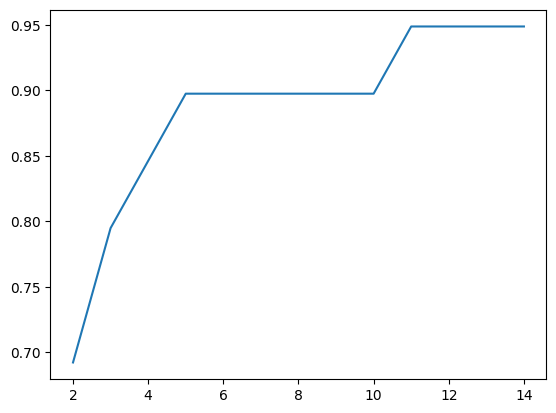

In [31]:
plt.plot(top_list, acc_list)

In [21]:
# 标签+向量3

In [14]:
def sub_worker(result, score, reason, top_n):
    if (filter_mask & (reason_indicator.str.find("errorcode")>=0)).sum() > 0:
        aug_mask = filter_mask & (reason_indicator.str.find("errorcode")>=0)
        filtered_df = df1[aug_mask].copy()
        filtered_df["hit_reason"] = reason_indicator[aug_mask].copy()
        res = search_docs_bge(filtered_df, question, top_n=int(top_n/2))
        result += [j["qa_id"] for j in res]
        score += [round(j["similarities"], 2) for j in res]
        reason += [j["hit_reason"] for j in res]
        
        aug_mask = filter_mask & (~(reason_indicator.str.find("errorcode")>=0))
        filtered_df = df1[aug_mask].copy()
        filtered_df["hit_reason"] = reason_indicator[aug_mask].copy()
        res = search_docs_bge(filtered_df, question, top_n=int(top_n/2))
        result += [j["qa_id"] for j in res]
        score += [round(j["similarities"], 2) for j in res]
        reason += [j["hit_reason"] for j in res]
    else:
        aug_mask = filter_mask
        filtered_df = df1[aug_mask].copy()
        filtered_df["hit_reason"] = reason_indicator[aug_mask].copy()
        res = search_docs_bge(filtered_df, question, top_n=int(top_n/2))
        result += [j["qa_id"] for j in res]
        score += [round(j["similarities"], 2) for j in res]
        reason += [j["hit_reason"] for j in res]
        
        aug_mask = (reason_indicator.str.find("errorcode")>=0)
        if aug_mask.sum() > 0:
            filtered_df = df1[aug_mask].copy()
            filtered_df["hit_reason"] = reason_indicator[aug_mask].copy()
            res = search_docs_bge(filtered_df, question, top_n=int(top_n/2))
            result += [j["qa_id"] for j in res]
            score += [round(j["similarities"], 2) for j in res]
            reason += [j["hit_reason"] for j in res]

    aug_mask = (~filter_mask) & (reason_indicator.str.find("cat")>=0)
    if aug_mask.sum() > 0:
        filtered_df = df1[aug_mask].copy()
        filtered_df["hit_reason"] = reason_indicator[aug_mask].copy()
        res = search_docs_bge(filtered_df, question, top_n=int(top_n/2))
        result += [j["qa_id"] for j in res]
        score += [round(j["similarities"], 2) for j in res]
        reason += [j["hit_reason"] for j in res]
    return result, score, reason
    
label = []
result_list = []
top_n = 10
for i in range(test.shape[0]):
    gt = test['gt_qa_id'].iloc[i].split(",")
    question = test['question'].iloc[i]
    model_list = find_model(question, all_model_list)
    cat_list = find_cat(question, all_cat_list)   
    cat_list += [cat for cat in dim_df.loc[dim_df.model.isin(model_list), 'cat_name'].tolist() if cat not in cat_list]
    reason_list = find_error_with_reason(question)
    model_mask = (df1.model_list.apply(lambda x: filter_model(x, model_list)))
    cat_mask = (df1.cat_name.apply(lambda x: filter_model(x, cat_list)))
    reason_mask = (df1.question.apply(lambda x: filter_reason(x, reason_list)))
    reason_indicator = pd.Series(["none"]*df1.shape[0], index=df1.index)
    reason_indicator[model_mask] = reason_indicator[model_mask].apply(lambda x: x + "|model" if x != "none" else "model")
    reason_indicator[cat_mask] = reason_indicator[cat_mask].apply(lambda x: x + "|cat" if x != "none" else "cat")
    reason_indicator[reason_mask] = reason_indicator[reason_mask].apply(lambda x: x + "|errorcode" if x != "none" else "errorcode")
    result = []
    score = []
    reason = []
    question = remove_model_name(question, all_model_list)
    filter_mask = (reason_indicator.str.find("model")>=0)
    if filter_mask.sum() > 0:
        result, score, reason = sub_worker(result, score, reason, top_n)
    else:
        filter_mask = (reason_indicator.str.find("cat")>=0)   
        if filter_mask.sum() > 0:
            result, score, reason = sub_worker(result, score, reason, top_n)
    if len(result) == 0:
        filter_mask = (reason_indicator.str.find("errorcode")>=0)
        if filter_mask.sum() > 0:
            aug_mask = filter_mask
            filtered_df = df1[aug_mask].copy()
            filtered_df["hit_reason"] = reason_indicator[aug_mask].copy()
            res = search_docs_bge(filtered_df, question, top_n=int(top_n/2))
            result += [j["qa_id"] for j in res]
            score += [round(j["similarities"], 2) for j in res]
            reason += [j["hit_reason"] for j in res]  
            aug_mask = (~filter_mask)
            filtered_df = df1[aug_mask].copy()
            filtered_df["hit_reason"] = reason_indicator[aug_mask].copy()
            res = search_docs_bge(filtered_df, question, top_n=int(top_n/2))
            result += [j["qa_id"] for j in res]
            score += [round(j["similarities"], 2) for j in res]
            reason += [j["hit_reason"] for j in res]  
        else:
            filtered_df = df1.copy()
            filtered_df["hit_reason"] = reason_indicator.copy()
            res = search_docs_bge(filtered_df, question, top_n=top_n)
            result += [j["qa_id"] for j in res]
            score += [round(j["similarities"], 2) for j in res]
            reason += [j["hit_reason"] for j in res]
    
    found = False
    for j in result:
        if j in gt:
            found = True
            break 
    if found:
        label.append(1)
    else:
        label.append(0)
    result_list.append({"qa_id": test['qa_id'].iloc[i], 
                        "result": result, 
                        "similarities": score, 
                        "hit_reason": reason, 
                        "label": int(found)})

In [15]:
result_df = pd.DataFrame(result_list)
test_result = test.merge(result_df, how='left', left_on='qa_id', right_on='qa_id')
test_result["sim_max"] = test_result["similarities"].apply(lambda x: max(x))
test_result["sim_min"] = test_result["similarities"].apply(lambda x: min(x))
test_result["result_num"] = test_result.result.apply(lambda x: len(x))

In [16]:
test_result.label.mean()

0.9487179487179487

In [17]:
top_list = range(2, 22, 2)
acc_list = []
for top_n in top_list:
    def sub_worker(result, score, reason, top_n):
        if (filter_mask & (reason_indicator.str.find("errorcode")>=0)).sum() > 0:
            aug_mask = filter_mask & (reason_indicator.str.find("errorcode")>=0)
            filtered_df = df1[aug_mask].copy()
            filtered_df["hit_reason"] = reason_indicator[aug_mask].copy()
            res = search_docs_bge(filtered_df, question, top_n=int(top_n/2))
            result += [j["qa_id"] for j in res]
            score += [round(j["similarities"], 2) for j in res]
            reason += [j["hit_reason"] for j in res]
            
            aug_mask = filter_mask & (~(reason_indicator.str.find("errorcode")>=0))
            filtered_df = df1[aug_mask].copy()
            filtered_df["hit_reason"] = reason_indicator[aug_mask].copy()
            res = search_docs_bge(filtered_df, question, top_n=int(top_n/2))
            result += [j["qa_id"] for j in res]
            score += [round(j["similarities"], 2) for j in res]
            reason += [j["hit_reason"] for j in res]
        else:
            aug_mask = filter_mask
            filtered_df = df1[aug_mask].copy()
            filtered_df["hit_reason"] = reason_indicator[aug_mask].copy()
            res = search_docs_bge(filtered_df, question, top_n=int(top_n/2))
            result += [j["qa_id"] for j in res]
            score += [round(j["similarities"], 2) for j in res]
            reason += [j["hit_reason"] for j in res]
            
            aug_mask = (reason_indicator.str.find("errorcode")>=0)
            if aug_mask.sum() > 0:
                filtered_df = df1[aug_mask].copy()
                filtered_df["hit_reason"] = reason_indicator[aug_mask].copy()
                res = search_docs_bge(filtered_df, question, top_n=int(top_n/2))
                result += [j["qa_id"] for j in res]
                score += [round(j["similarities"], 2) for j in res]
                reason += [j["hit_reason"] for j in res]
    
        aug_mask = (~filter_mask) & (reason_indicator.str.find("cat")>=0)
        if aug_mask.sum() > 0:
            filtered_df = df1[aug_mask].copy()
            filtered_df["hit_reason"] = reason_indicator[aug_mask].copy()
            res = search_docs_bge(filtered_df, question, top_n=int(top_n/2))
            result += [j["qa_id"] for j in res]
            score += [round(j["similarities"], 2) for j in res]
            reason += [j["hit_reason"] for j in res]
        return result, score, reason
    label = []
    result_list = []
    for i in range(test.shape[0]):
        gt = test['gt_qa_id'].iloc[i].split(",")
        question = test['question'].iloc[i]
        model_list = find_model(question, all_model_list)
        cat_list = find_cat(question, all_cat_list)   
        cat_list += [cat for cat in dim_df.loc[dim_df.model.isin(model_list), 'cat_name'].tolist() if cat not in cat_list]
        reason_list = find_error_with_reason(question)
        model_mask = (df1.model_list.apply(lambda x: filter_model(x, model_list)))
        cat_mask = (df1.cat_name.apply(lambda x: filter_model(x, cat_list)))
        reason_mask = (df1.question.apply(lambda x: filter_reason(x, reason_list)))
        reason_indicator = pd.Series(["none"]*df1.shape[0], index=df1.index)
        reason_indicator[model_mask] = reason_indicator[model_mask].apply(lambda x: x + "|model" if x != "none" else "model")
        reason_indicator[cat_mask] = reason_indicator[cat_mask].apply(lambda x: x + "|cat" if x != "none" else "cat")
        reason_indicator[reason_mask] = reason_indicator[reason_mask].apply(lambda x: x + "|errorcode" if x != "none" else "errorcode")
        result = []
        score = []
        reason = []
        question = remove_model_name(question, all_model_list)
        filter_mask = (reason_indicator.str.find("model")>=0)
        if filter_mask.sum() > 0:
            result, score, reason = sub_worker(result, score, reason, top_n)
        else:
            filter_mask = (reason_indicator.str.find("cat")>=0)   
            if filter_mask.sum() > 0:
                result, score, reason = sub_worker(result, score, reason, top_n)
        if len(result) == 0:
            filter_mask = (reason_indicator.str.find("errorcode")>=0)
            if filter_mask.sum() > 0:
                aug_mask = filter_mask
                filtered_df = df1[aug_mask].copy()
                filtered_df["hit_reason"] = reason_indicator[aug_mask].copy()
                res = search_docs_bge(filtered_df, question, top_n=int(top_n/2))
                result += [j["qa_id"] for j in res]
                score += [round(j["similarities"], 2) for j in res]
                reason += [j["hit_reason"] for j in res]  
                aug_mask = (~filter_mask)
                filtered_df = df1[aug_mask].copy()
                filtered_df["hit_reason"] = reason_indicator[aug_mask].copy()
                res = search_docs_bge(filtered_df, question, top_n=int(top_n/2))
                result += [j["qa_id"] for j in res]
                score += [round(j["similarities"], 2) for j in res]
                reason += [j["hit_reason"] for j in res]  
            else:
                filtered_df = df1.copy()
                filtered_df["hit_reason"] = reason_indicator.copy()
                res = search_docs_bge(filtered_df, question, top_n=top_n)
                result += [j["qa_id"] for j in res]
                score += [round(j["similarities"], 2) for j in res]
                reason += [j["hit_reason"] for j in res]
        
        found = False
        for j in result:
            if j in gt:
                found = True
                break 
        if found:
            label.append(1)
        else:
            label.append(0)
        result_list.append({"qa_id": test['qa_id'].iloc[i], 
                            "result": result, 
                            "similarities": score, 
                            "hit_reason": reason, 
                            "label": int(found)})
    acc_list.append(sum(label)/len(label))

In [18]:
for i, j in zip(top_list, acc_list):
    print(i, j)

2 0.8205128205128205
4 0.8461538461538461
6 0.8717948717948718
8 0.9230769230769231
10 0.9487179487179487
12 0.9487179487179487
14 0.9487179487179487
16 0.9487179487179487
18 0.9487179487179487
20 0.9743589743589743


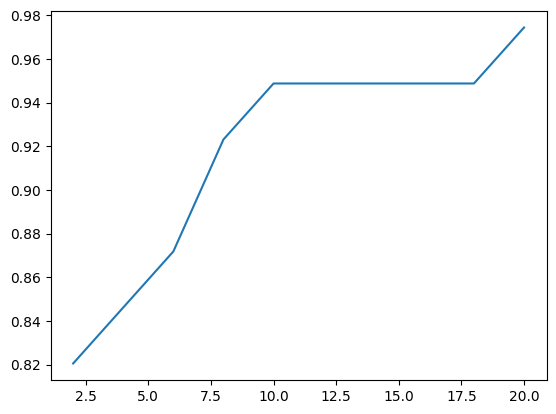

In [19]:
plt.plot(top_list, acc_list)

In [20]:
# 标签+bm25

In [17]:
wc = WordCut(all_model_list)

In [18]:
document_list = [wc.cut(doc) for doc in df1.question]
bm25_model = BM25_Model(document_list)

Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 1.000 seconds.
Prefix dict has been built successfully.


In [19]:
def sub_worker_bm25(result, score, reason, top_n):
    if (filter_mask & (reason_indicator.str.find("errorcode")>=0)).sum() > 0:
        aug_mask = filter_mask & (reason_indicator.str.find("errorcode")>=0)
        filtered_df = df1[aug_mask].copy()
        filtered_indices = np.array(range(df1.shape[0]))[aug_mask.values]
        filtered_df["hit_reason"] = reason_indicator[aug_mask].copy()
        res = search_docs_bm25(filtered_df, filtered_indices, question, top_n=int(top_n/2))
        result += [j["qa_id"] for j in res]
        score += [round(j["similarities"], 2) for j in res]
        reason += [j["hit_reason"] for j in res]
        
        aug_mask = filter_mask & (~(reason_indicator.str.find("errorcode")>=0))
        filtered_df = df1[aug_mask].copy()
        filtered_indices = np.array(range(df1.shape[0]))[aug_mask.values]
        filtered_df["hit_reason"] = reason_indicator[aug_mask].copy()
        res = search_docs_bm25(filtered_df, filtered_indices, question, top_n=int(top_n/2))
        result += [j["qa_id"] for j in res]
        score += [round(j["similarities"], 2) for j in res]
        reason += [j["hit_reason"] for j in res]
    else:
        aug_mask = filter_mask
        filtered_df = df1[aug_mask].copy()
        filtered_indices = np.array(range(df1.shape[0]))[aug_mask.values]
        filtered_df["hit_reason"] = reason_indicator[aug_mask].copy()
        res = search_docs_bm25(filtered_df, filtered_indices, question, top_n=int(top_n/2))
        result += [j["qa_id"] for j in res]
        score += [round(j["similarities"], 2) for j in res]
        reason += [j["hit_reason"] for j in res]
        
        aug_mask = (reason_indicator.str.find("errorcode")>=0)
        if aug_mask.sum() > 0:
            filtered_df = df1[aug_mask].copy()
            filtered_indices = np.array(range(df1.shape[0]))[aug_mask.values]
            filtered_df["hit_reason"] = reason_indicator[aug_mask].copy()
            res = search_docs_bm25(filtered_df, filtered_indices, question, top_n=int(top_n/2))
            result += [j["qa_id"] for j in res]
            score += [round(j["similarities"], 2) for j in res]
            reason += [j["hit_reason"] for j in res]

    aug_mask = (~filter_mask) & (reason_indicator.str.find("cat")>=0)
    # aug_mask = (~filter_mask) & (~(reason_indicator.str.find("errorcode")>=0)) & (reason_indicator.str.find("cat")>=0)
    if aug_mask.sum() > 0:
        filtered_df = df1[aug_mask].copy()
        filtered_indices = np.array(range(df1.shape[0]))[aug_mask.values]
        filtered_df["hit_reason"] = reason_indicator[aug_mask].copy()
        res = search_docs_bm25(filtered_df, filtered_indices, question, top_n=int(top_n/2))
        result += [j["qa_id"] for j in res]
        score += [round(j["similarities"], 2) for j in res]
        reason += [j["hit_reason"] for j in res]

    return result, score, reason

label = []
result_list = []
top_n = 10
for i in range(test.shape[0]):
    gt = test['gt_qa_id'].iloc[i].split(",")
    question = test['question'].iloc[i]
    model_list = find_model(question, all_model_list)
    cat_list = find_cat(question, all_cat_list)   
    cat_list += [cat for cat in dim_df.loc[dim_df.model.isin(model_list), 'cat_name'].tolist() if cat not in cat_list]
    reason_list = find_error_with_reason(question)
    model_mask = (df1.model_list.apply(lambda x: filter_model(x, model_list)))
    cat_mask = (df1.cat_name.apply(lambda x: filter_model(x, cat_list)))
    reason_mask = (df1.question.apply(lambda x: filter_reason(x, reason_list)))
    reason_indicator = pd.Series(["none"]*df1.shape[0], index=df1.index)
    reason_indicator[model_mask] = reason_indicator[model_mask].apply(lambda x: x + "|model" if x != "none" else "model")
    reason_indicator[cat_mask] = reason_indicator[cat_mask].apply(lambda x: x + "|cat" if x != "none" else "cat")
    reason_indicator[reason_mask] = reason_indicator[reason_mask].apply(lambda x: x + "|errorcode" if x != "none" else "errorcode")
    result = []
    score = []
    reason = []
    question = remove_model_name(question, all_model_list)
    filter_mask = (reason_indicator.str.find("model")>=0)
    if filter_mask.sum() > 0:
        result, score, reason = sub_worker_bm25(result, score, reason, top_n)
    else:
        filter_mask = (reason_indicator.str.find("cat")>=0)   
        if filter_mask.sum() > 0:
            result, score, reason = sub_worker_bm25(result, score, reason, top_n)
    if len(result) == 0:
        filter_mask = (reason_indicator.str.find("errorcode")>=0)
        if filter_mask.sum() > 0:
            aug_mask = filter_mask
            filtered_df = df1[aug_mask].copy()
            filtered_indices = np.array(range(df1.shape[0]))[aug_mask.values]
            filtered_df["hit_reason"] = reason_indicator[aug_mask].copy()
            res = search_docs_bm25(filtered_df, filtered_indices, question, top_n=int(top_n/2))
            result += [j["qa_id"] for j in res]
            score += [round(j["similarities"], 2) for j in res]
            reason += [j["hit_reason"] for j in res]  
            aug_mask = (~filter_mask)
            filtered_df = df1[aug_mask].copy()
            filtered_indices = np.array(range(df1.shape[0]))[aug_mask.values]
            filtered_df["hit_reason"] = reason_indicator[aug_mask].copy()
            res = search_docs_bm25(filtered_df, filtered_indices, question, top_n=int(top_n/2))
            result += [j["qa_id"] for j in res]
            score += [round(j["similarities"], 2) for j in res]
            reason += [j["hit_reason"] for j in res]  
        else:
            filtered_df = df1.copy()
            filtered_df["hit_reason"] = reason_indicator.copy()
            filtered_indices = np.array(range(df1.shape[0]))
            res = search_docs_bm25(filtered_df, filtered_indices, question, top_n=top_n)
            result += [j["qa_id"] for j in res]
            score += [round(j["similarities"], 2) for j in res]
            reason += [j["hit_reason"] for j in res]
    # result_list.append({"qa_id": test['qa_id'].iloc[i], "result": result, "similarities": score, "hit_reason": reason})
    found = False
    for j in result:
        if j in gt:
            found = True
            break 
    if found:
        label.append(1)
    else:
        label.append(0)
    result_list.append({"qa_id": test['qa_id'].iloc[i], "result": result, "similarities": score, "hit_reason": reason, "label": int(found)})

In [20]:
result_df = pd.DataFrame(result_list)
test_result2 = test.merge(result_df, how='left', left_on='qa_id', right_on='qa_id')
test_result2["sim_max"] = test_result2["similarities"].apply(lambda x: max(x) if len(x)>0 else np.nan)
test_result2["sim_min"] = test_result2["similarities"].apply(lambda x: min(x) if len(x)>0 else np.nan)
test_result2["result_num"] = test_result2.result.apply(lambda x: len(x))

In [21]:
test_result2.label.mean()

0.8205128205128205

In [38]:
top_list = range(2, 22, 2)
acc_list = []
for top_n in top_list:
    label = []
    result_list = []
    for i in range(test.shape[0]):
        gt = test['gt_qa_id'].iloc[i].split(",")
        question = test['question'].iloc[i]
        model_list = find_model(question, all_model_list)
        cat_list = find_cat(question, all_cat_list)   
        cat_list += [cat for cat in dim_df.loc[dim_df.model.isin(model_list), 'cat_name'].tolist() if cat not in cat_list]
        reason_list = find_error_with_reason(question)
        model_mask = (df1.model_list.apply(lambda x: filter_model(x, model_list)))
        cat_mask = (df1.cat_name.apply(lambda x: filter_model(x, cat_list)))
        reason_mask = (df1.question.apply(lambda x: filter_reason(x, reason_list)))
        reason_indicator = pd.Series(["none"]*df1.shape[0], index=df1.index)
        reason_indicator[model_mask] = reason_indicator[model_mask].apply(lambda x: x + "|model" if x != "none" else "model")
        reason_indicator[cat_mask] = reason_indicator[cat_mask].apply(lambda x: x + "|cat" if x != "none" else "cat")
        reason_indicator[reason_mask] = reason_indicator[reason_mask].apply(lambda x: x + "|errorcode" if x != "none" else "errorcode")
        result = []
        score = []
        reason = []
        question = remove_model_name(question, all_model_list)
        filter_mask = (reason_indicator.str.find("model")>=0)
        if filter_mask.sum() > 0:
            result, score, reason = sub_worker_bm25(result, score, reason, top_n)
        else:
            filter_mask = (reason_indicator.str.find("cat")>=0)   
            if filter_mask.sum() > 0:
                result, score, reason = sub_worker_bm25(result, score, reason, top_n)
        if len(result) == 0:
            filter_mask = (reason_indicator.str.find("errorcode")>=0)
            if filter_mask.sum() > 0:
                aug_mask = filter_mask
                filtered_df = df1[aug_mask].copy()
                filtered_indices = np.array(range(df1.shape[0]))[aug_mask.values]
                filtered_df["hit_reason"] = reason_indicator[aug_mask].copy()
                res = search_docs_bm25(filtered_df, filtered_indices, question, top_n=int(top_n/2))
                result += [j["qa_id"] for j in res]
                score += [round(j["similarities"], 2) for j in res]
                reason += [j["hit_reason"] for j in res]  
                aug_mask = (~filter_mask)
                filtered_df = df1[aug_mask].copy()
                filtered_indices = np.array(range(df1.shape[0]))[aug_mask.values]
                filtered_df["hit_reason"] = reason_indicator[aug_mask].copy()
                res = search_docs_bm25(filtered_df, filtered_indices, question, top_n=int(top_n/2))
                result += [j["qa_id"] for j in res]
                score += [round(j["similarities"], 2) for j in res]
                reason += [j["hit_reason"] for j in res]  
            else:
                filtered_df = df1.copy()
                filtered_indices = np.array(range(df1.shape[0]))
                filtered_df["hit_reason"] = reason_indicator.copy()
                res = search_docs_bm25(filtered_df, filtered_indices, question, top_n=top_n)
                result += [j["qa_id"] for j in res]
                score += [round(j["similarities"], 2) for j in res]
                reason += [j["hit_reason"] for j in res]
        # result_list.append({"qa_id": test['qa_id'].iloc[i], "result": result, "similarities": score, "hit_reason": reason})
        found = False
        for j in result:
            if j in gt:
                found = True
                break 
        if found:
            label.append(1)
        else:
            label.append(0)
        result_list.append({"qa_id": test['qa_id'].iloc[i], "result": result, "similarities": score, "hit_reason": reason, "label": int(found)})
    acc_list.append(sum(label)/len(label))

In [39]:
for i, j in zip(top_list, acc_list):
    print(i, j)

2 0.717948717948718
4 0.7435897435897436
6 0.7435897435897436
8 0.8205128205128205
10 0.8205128205128205
12 0.8461538461538461
14 0.8717948717948718
16 0.8974358974358975
18 0.8974358974358975
20 0.8974358974358975


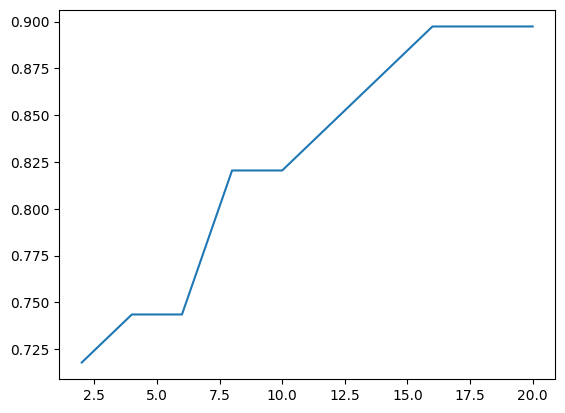

In [40]:
plt.plot(top_list, acc_list)

# 综合分析

In [22]:
final_result = pd.merge(left=test_result, right=test_result2[["qa_id",
                                               "result",
                                               "similarities",
                                               "hit_reason",
                                               "label",
                                               "sim_max",
                                               "sim_min",
                                               "result_num"]], 
                 left_on="qa_id", right_on="qa_id", how="left",
                 suffixes=["_bge", "_bm25"])

In [23]:
final_result['label_all'] = final_result[["label_bge", "label_bm25"]].apply(lambda x: max(x["label_bge"], x["label_bm25"]), axis=1)

In [24]:
final_result.label_all.mean()

0.9487179487179487

In [25]:
min_all, max_all = find_score_limit(final_result["similarities_bm25"].tolist())
final_result["similarities_rescaled_bm25"] = final_result["similarities_bm25"].apply(
    lambda x: convert_limit(x, min_all, max_all))

In [26]:
cols = ["similarities_bge", "hit_reason_bge", "result_bge"]
final_result["recall_bge"] = final_result[cols].apply(lambda x: format_result(x, *cols), axis=1) 
cols = ["similarities_rescaled_bm25", "hit_reason_bm25", "result_bm25"]
final_result["recall_bm25"] = final_result[cols].apply(lambda x: format_result(x, *cols), axis=1) 
final_result["recall_all"] = final_result[["recall_bge", "recall_bm25"]].apply(
    lambda x: merge_recall(x, 
                           recall_list=["recall_bge", "recall_bm25"], 
                           weights=[0.9, 0.84]
                          ), 
    axis=1) 

In [27]:
final_result["recall_hard"] = final_result[["recall_all", "gt_qa_id"]].apply(
    lambda x: mine_hard_negative2(x, 
                                  "recall_all", 
                                  positive='gt_qa_id', 
                                  top_n=20,
                                  output_cols=["result", "reason", "full_reason", "similarities"]
                                 ), 
    axis=1) 

In [28]:
cols = ["similarities", "reason", "full_reason", "result"]
new_cols = ["similarities_merge_hard", "reason_merge_hard", "full_reason_merge_hard", "result_merge_hard"]
final_result[new_cols] = final_result["recall_hard"].apply(lambda x: split_recall(x, cols, new_cols))

In [29]:
final_result['result_num_bge_set'] = final_result.recall_bge.apply(lambda x: len(x))
final_result['result_num_bm25_set'] = final_result.recall_bm25.apply(lambda x: len(x))
final_result['result_num_all_set'] = final_result.recall_all.apply(lambda x: len(x))

In [143]:
# 检查结果

In [353]:
check_col = "bge"
a = final_result[final_result[f"result_num_{check_col}_set"]!=final_result[f"result_num_{check_col}"]].iloc[0]
temp = pd.DataFrame(a[f'recall_{check_col}'])
temp = temp.rename(columns={"result": f"recall_{check_col}"})
result_temp = pd.DataFrame(a[[f"result_{check_col}", f"similarities_{check_col}", f"hit_reason_{check_col}"]].to_dict())
result_temp['duplicated'] = result_temp[f"result_{check_col}"].duplicated()
result_temp.merge(temp, how='left', left_on=f'result_{check_col}', right_on=f'recall_{check_col}').sort_values(f"result_{check_col}")

,result_bge,similarities_bge,hit_reason_bge,duplicated,recall_bge,reason,similarities
20,STKF2306253829,0.63,cat,False,STKF2306253829,cat,0.63
16,STKF2306253831,0.63,cat,False,STKF2306253831,cat,0.63
14,STKF2306253832,0.67,cat,False,STKF2306253832,cat,0.67
15,STKF2306253833,0.66,cat,False,STKF2306253833,cat,0.66
12,STKF2306253834,0.69,cat,False,STKF2306253834,cat,0.69
17,STKF2306253835,0.63,cat,False,STKF2306253835,cat,0.63
18,STKF2306253836,0.63,cat,False,STKF2306253836,cat,0.63
19,STKF2306253837,0.63,cat,False,STKF2306253837,cat,0.63
0,STKF2306253838,0.68,model|cat,False,STKF2306253838,model|cat,0.68
9,STKF2306253843,0.50,model|cat,False,STKF2306253843,model|cat,0.50


In [263]:
check_col = "bm25"
a = final_result[final_result[f"result_num_{check_col}_set"]!=final_result[f"result_num_{check_col}"]].iloc[0]
temp = pd.DataFrame(a[f'recall_{check_col}'])
temp = temp.rename(columns={"result": f"recall_{check_col}"})
result_temp = pd.DataFrame(a[[f"result_{check_col}", f"similarities_{check_col}", f"hit_reason_{check_col}"]].to_dict())
result_temp['duplicated'] = result_temp[f"result_{check_col}"].duplicated()
result_temp.merge(temp, how='left', left_on=f'result_{check_col}', right_on=f'recall_{check_col}').sort_values(f"result_{check_col}")

,result_bm25,similarities_bm25,hit_reason_bm25,duplicated,recall_bm25,similarities,reason
21,STKF2306253830,4.08,cat,False,STKF2306253830,0.14417,cat
20,STKF2306253831,4.08,cat,False,STKF2306253831,0.14417,cat
19,STKF2306253832,4.08,cat,False,STKF2306253832,0.14417,cat
18,STKF2306253833,4.08,cat,False,STKF2306253833,0.14417,cat
17,STKF2306253834,4.08,cat,False,STKF2306253834,0.14417,cat
16,STKF2306253835,4.08,cat,False,STKF2306253835,0.14417,cat
15,STKF2306253836,4.41,cat,False,STKF2306253836,0.15583,cat
14,STKF2306253837,4.41,cat,False,STKF2306253837,0.15583,cat
0,STKF2306253838,4.41,model|cat,False,STKF2306253838,0.15583,model|cat
9,STKF2306253844,3.79,model|cat,False,STKF2306253844,0.133922,model|cat


In [355]:
check_col = "bm25"
a = final_result[final_result[f"result_num_{check_col}_set"]!=final_result[f"result_num_{check_col}"]].iloc[0]

check_col = "bm25"
temp = pd.DataFrame(a[f'recall_{check_col}'])
temp = temp.rename(columns={"result": f"recall_{check_col}"})
result_temp = pd.DataFrame(a[[f"result_{check_col}", f"similarities_{check_col}", f"hit_reason_{check_col}"]].to_dict())
result_temp['duplicated'] = result_temp[f"result_{check_col}"].duplicated()
result_temp = result_temp.merge(temp, how='left', 
                                left_on=f'result_{check_col}', 
                                right_on=f'recall_{check_col}').sort_values(f"result_{check_col}")
result_temp = result_temp.rename(columns={"similarities": "recall_similarities_bm25", 
                                          "reason": "recall_reason_bm25",
                                          "duplicated": "duplicated_bm25"})

check_col = "bge"
temp2 = pd.DataFrame(a[f'recall_{check_col}'])
temp2 = temp2.rename(columns={"result": f"recall_{check_col}"})
result_temp2 = pd.DataFrame(a[[f"result_{check_col}", f"similarities_{check_col}", f"hit_reason_{check_col}"]].to_dict())
result_temp2['duplicated'] = result_temp2[f"result_{check_col}"].duplicated()
result_temp2 = result_temp2.merge(temp2, how='left', 
                                  left_on=f'result_{check_col}', 
                                  right_on=f'recall_{check_col}').sort_values(f"result_{check_col}")
result_temp2 = result_temp2.rename(columns={"similarities": "recall_similarities_bge", 
                                            "reason": "recall_reason_bge",
                                            "duplicated": "duplicated_bge"})

new_cols = ["similarities_merge_hard", "reason_merge_hard", "full_reason_merge_hard", "result_merge_hard"]
result_temp3 = pd.DataFrame(a[new_cols].to_dict())

In [315]:
result_temp.merge(result_temp2, 
                  how='outer', 
                  left_on="result_bm25",
                  right_on='result_bge', 
                 ).merge(result_temp3, 
                         how='outer', 
                         left_on="result_bm25",
                         right_on='result_merge_hard',
                        )

,result_bm25,similarities_bm25,hit_reason_bm25,duplicated_bm25,recall_bm25,recall_similarities_bm25,recall_reason_bm25,result_bge,similarities_bge,hit_reason_bge,duplicated_bge,recall_bge,recall_similarities_bge,recall_reason_bge,similarities_merge_hard,reason_merge_hard,full_reason_merge_hard,result_merge_hard
0,STKF2306253830,4.08,cat,False,STKF2306253830,0.14417,cat,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,STKF2306253831,4.08,cat,False,STKF2306253831,0.14417,cat,STKF2306253831,0.63,cat,False,STKF2306253831,0.63,cat,NaN,NaN,NaN,NaN
2,STKF2306253832,4.08,cat,False,STKF2306253832,0.14417,cat,STKF2306253832,0.67,cat,False,STKF2306253832,0.67,cat,NaN,NaN,NaN,NaN
3,STKF2306253833,4.08,cat,False,STKF2306253833,0.14417,cat,STKF2306253833,0.66,cat,False,STKF2306253833,0.66,cat,NaN,NaN,NaN,NaN
4,STKF2306253834,4.08,cat,False,STKF2306253834,0.14417,cat,STKF2306253834,0.69,cat,False,STKF2306253834,0.69,cat,NaN,NaN,NaN,NaN
5,STKF2306253835,4.08,cat,False,STKF2306253835,0.14417,cat,STKF2306253835,0.63,cat,False,STKF2306253835,0.63,cat,NaN,NaN,NaN,NaN
6,STKF2306253836,4.41,cat,False,STKF2306253836,0.15583,cat,STKF2306253836,0.63,cat,False,STKF2306253836,0.63,cat,NaN,NaN,NaN,NaN
7,STKF2306253837,4.41,cat,False,STKF2306253837,0.15583,cat,STKF2306253837,0.63,cat,False,STKF2306253837,0.63,cat,NaN,NaN,NaN,NaN
8,STKF2306253838,4.41,model|cat,False,STKF2306253838,0.15583,model|cat,STKF2306253838,0.68,model|cat,False,STKF2306253838,0.68,model|cat,0.426953,model|cat,"model|cat_recall_bge,model|cat_recall_bm25",STKF2306253838
9,STKF2306253844,3.79,model|cat,False,STKF2306253844,0.133922,model|cat,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [367]:
# 只做向量

In [30]:
cols = ["similarities_bge", "hit_reason_bge", "result_bge", "gt_qa_id"]
new_cols = [col+"_hard" for col in cols if col != "gt_qa_id"]

In [31]:
final_result[new_cols] = final_result[cols].apply(lambda x: mine_hard_negative(x, *cols), axis=1) 

In [32]:
final_result.shape

(39, 41)

In [368]:
# 制作数据集

In [32]:
temp = final_result.copy()
temp_exploded = temp.explode("result_merge_hard")[['qa_id', 'result_merge_hard']]
temp_right = df1[['qa_id', 
               'question', 
               'answer']].copy()
temp_exploded = pd.merge(left=temp_exploded, right=temp_right, 
                         left_on='result_merge_hard', right_on='qa_id', 
                         how='left', suffixes=["", "_merge_hard"])[["qa_id", "result_merge_hard", "question", "answer"]]
temp_exploded = temp_exploded.rename(columns={"question": "question_merge_hard", "answer": "answer_merge_hard"})
temp_exploded = temp_exploded.groupby("qa_id")[["question_merge_hard", "answer_merge_hard"]].apply(
    lambda x: pd.Series({col: x[col].tolist() for col in x.columns}))


In [33]:
final_result = pd.merge(left=final_result, right=temp_exploded,
                        left_on='qa_id', right_on='qa_id', how='left')

In [34]:
temp = final_result.copy()
temp_exploded = temp.explode("result_bge_hard")[['qa_id', 'result_bge_hard']]
temp_right = df1[['qa_id', 
               'question', 
               'answer']].copy()
temp_exploded = pd.merge(left=temp_exploded, right=temp_right, 
                         left_on='result_bge_hard', right_on='qa_id', 
                         how='left', suffixes=["", "_bge_hard"])[["qa_id", "result_bge_hard", "question", "answer"]]
temp_exploded = temp_exploded.rename(columns={"question": "question_bge_hard", "answer": "answer_bge_hard"})
temp_exploded = temp_exploded.groupby("qa_id")[["question_bge_hard", "answer_bge_hard"]].apply(
    lambda x: pd.Series({col: x[col].tolist() for col in x.columns}))

In [35]:
final_result = pd.merge(left=final_result, right=temp_exploded,
                        left_on='qa_id', right_on='qa_id', how='left')

In [36]:
temp = final_result.copy()
temp['gt_qa_id'] = temp['gt_qa_id'].apply(lambda x: x.split(","))
temp_exploded = temp.explode("gt_qa_id")[['qa_id', 'gt_qa_id']]
temp_right = df1[['qa_id', 
               'question', 
               'answer']].copy()
temp_exploded = pd.merge(left=temp_exploded, right=temp_right, 
                         left_on='gt_qa_id', right_on='qa_id', 
                         how='left', suffixes=["", "_kg"])[["qa_id", "gt_qa_id", "question", "answer"]]
temp_exploded = temp_exploded.rename(columns={"question": "question_positive", "answer": "answer_positive"})
temp_exploded = temp_exploded.groupby("qa_id")[["question_positive", "answer_positive"]].apply(
    lambda x: pd.Series({col: x[col].tolist() for col in x.columns}))
final_result = pd.merge(left=final_result, right=temp_exploded,
                        left_on='qa_id', right_on='qa_id', how='left')

In [37]:
final_result["question_cleaned"] = final_result["question"].apply(lambda x: remove_model_name(x, all_model_list))

In [38]:
# 用来检验bge ranker微调后的模型在oot的效果的数据集（采用finetuned embedding模型召回后，每路召回取前10个，融合取前20个）
joblib.dump(final_result, "/data/dataset/kefu/final_result_oot_emb_finetuned_top20.csv")

['/data/dataset/kefu/final_result_oot_emb_finetuned_top20.csv']

# 排序

In [150]:
final_result = joblib.load("/data/dataset/kefu/final_result_oot_emb_finetuned_top20.csv")

In [39]:
# model_reranker = FlagReranker("/data/dataset/huggingface/hub/bge-reranker-large", use_fp16=True)
model_reranker = FlagReranker("/workspace/data/private/zhuxiaohai/models/bge_finetune_reranker_question_top20", use_fp16=True)

In [40]:
recall_list = ["recall_bge", "recall_bm25", "recall_all"]
top_n = [1, 2]
use_sim_score = False
result_all = {}
result_T_loc = {}
result_reranking = {}
preranking = None
target = "question"
postranking = True
for recall in recall_list:
    # 召回特性
    temp = final_result.copy()
    if preranking is not None:
        temp[recall] = temp[recall].apply(lambda x: x[:preranking])
    temp[f"{recall}_all"] = temp[recall].apply(lambda x: [i["result"] for i in x])
    temp["relevant"] = temp[[f"{recall}_all", "gt_qa_id"]].apply(
        lambda x: [True if i in x["gt_qa_id"].split(",") else False for i in x[f"{recall}_all"]], axis=1)
    temp_exploded = temp.explode(f"{recall}_all")[['qa_id', f"{recall}_all"]]
    temp_right = df1[['qa_id', 'question', 'answer']].copy()
    temp_exploded = pd.merge(left=temp_exploded, right=temp_right, 
                             left_on=f"{recall}_all", right_on='qa_id', 
                             how='left', suffixes=["", "_right"])[["qa_id", f"{recall}_all", "question", "answer"]]
    temp_exploded = temp_exploded.groupby("qa_id")[["question", "answer"]].apply(
        lambda x: pd.Series({col: x[col].tolist() for col in x.columns}))
    temp = pd.merge(left=temp[["qa_id", "question_cleaned", f"{recall}_all", "relevant", recall]], right=temp_exploded,
                    left_on='qa_id', right_on='qa_id', how='left')
    if use_sim_score:
        temp["score"] = temp[f"{recall}_all"].apply(lambda x: list(range(len(x)))[::-1])
    else:
        temp["score"] = compute_recall_score(temp, model_reranker, "question_cleaned", target)
    # T_loc = temp[["relevant", "score"]].apply(lambda x: find_T_loc(x, "relevant", "score"), axis=1)
    if recall.find("_all") >= 0:
        reason = "full_reason"
    else:
        reason = "reason"
    result_reranking[recall] = temp[["relevant", "score", recall]].apply(
        lambda x: get_reranking(x, "relevant", "score", recall, reason, postranking), axis=1)
    # result_T_loc[recall] = T_loc
    if postranking:
        temp["score"] = [[j["reranking_score"] for j in i] for i in result_reranking[recall]] 
        temp["relevant"] = [[j["relevant"] for j in i] for i in result_reranking[recall]]
    T_loc = temp[["relevant", "score"]].apply(lambda x: find_T_loc(x, "relevant", "score"), axis=1)
    result_T_loc[recall] = T_loc
    result_all[recall] = compute_metrics_batched_from_crossencoder(temp, "score", "relevant", metrics=["recall"], recall_at_list=top_n)

    # 排序特性
    temp = final_result.copy()
    if preranking is not None:
        temp[recall] = temp[recall].apply(lambda x: x[:preranking])
    temp[f"{recall}_all"] = temp[recall].apply(lambda x: [i["result"] for i in x])
    temp[f"{recall}_all"] = temp[[f"{recall}_all", "gt_qa_id"]].apply(lambda x: x[f"{recall}_all"] + [
        i for i in x["gt_qa_id"].split(",") if i not in x[f"{recall}_all"]], axis=1)
    temp["relevant"] = temp[[f"{recall}_all", "gt_qa_id"]].apply(
        lambda x: [True if i in x["gt_qa_id"].split(",") else False for i in x[f"{recall}_all"]], axis=1)
    temp_exploded = temp.explode(f"{recall}_all")[['qa_id', f"{recall}_all"]]
    temp_right = df1[['qa_id', 'question', 'answer']].copy()
    temp_exploded = pd.merge(left=temp_exploded, right=temp_right, 
                             left_on=f"{recall}_all", right_on='qa_id', 
                             how='left', suffixes=["", "_right"])[["qa_id", f"{recall}_all", "question", "answer"]]
    temp_exploded = temp_exploded.groupby("qa_id")[["question", "answer"]].apply(
        lambda x: pd.Series({col: x[col].tolist() for col in x.columns}))
    temp = pd.merge(left=temp[["qa_id", "question_cleaned", f"{recall}_all", "relevant"]], right=temp_exploded,
                    left_on='qa_id', right_on='qa_id', how='left')
    if use_sim_score:
        temp["score"] = temp[f"{recall}_all"].apply(lambda x: list(range(len(x)))[::-1])
    else:
        temp["score"] = compute_recall_score(temp, model_reranker, "question_cleaned", target)
    result_all[recall].update(compute_metrics_batched_from_crossencoder(temp, "score", "relevant", metrics=["map", "mrr"]))

Compute Scores: 100%|█████████████████████████████| 3/3 [00:00<00:00,  7.27it/s]


In [66]:
# 直接用召回的相似度来排序
a = pd.DataFrame(result_T_loc)
cols = a.columns.tolist()
len_cols = [a[col].unique().shape[0] for col in cols]
anchor = cols[np.argmax(len_cols)]
stat = a[anchor].fillna(100).value_counts("mean").sort_index().reset_index()
for col in [col for col in cols if col != anchor]:
    temp = a[col].fillna(100).value_counts("mean").sort_index().reset_index()
    stat = pd.merge(left=stat, right=temp, left_on=anchor, right_on=col, how="outer")
stat

,recall_all,proportion_x,recall_bge,proportion_y,recall_bm25,proportion
0,0.0,0.717949,0.0,0.717949,0.0,0.666667
1,1.0,0.025641,1.0,0.025641,1.0,0.025641
2,2.0,0.025641,2.0,0.025641,NaN,NaN
3,NaN,NaN,NaN,NaN,3.0,0.051282
4,4.0,0.051282,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,5.0,0.051282
6,7.0,0.025641,NaN,NaN,NaN,NaN
7,8.0,0.025641,NaN,NaN,8.0,0.025641
8,9.0,0.051282,9.0,0.025641,NaN,NaN
9,10.0,0.025641,NaN,NaN,NaN,NaN


In [41]:
# 直接用召回的相似度来排序
pd.DataFrame(result_all)

,recall_bge,recall_bm25,recall_all
recall@1,0.717949,0.666667,0.717949
recall@2,0.743590,0.692308,0.743590
map,0.778399,0.721963,0.766841
mrr@10,0.776068,0.707977,0.760755


In [44]:
# 用原始bge ranker模型排序
a = pd.DataFrame(result_T_loc)
cols = a.columns.tolist()
len_cols = [a[col].unique().shape[0] for col in cols]
anchor = cols[np.argmax(len_cols)]
stat = a[anchor].fillna(100).value_counts("mean").sort_index().reset_index()
for col in [col for col in cols if col != anchor]:
    temp = a[col].fillna(100).value_counts("mean").sort_index().reset_index()
    stat = pd.merge(left=stat, right=temp, left_on=anchor, right_on=col, how="outer")
stat

,recall_all,proportion_x,recall_bge,proportion_y,recall_bm25,proportion
0,0.0,0.179487,0.0,0.205128,0.0,0.333333
1,1.0,0.128205,1.0,0.102564,1.0,0.102564
2,2.0,0.128205,2.0,0.153846,2.0,0.051282
3,3.0,0.076923,3.0,0.076923,3.0,0.102564
4,4.0,0.025641,4.0,0.076923,4.0,0.076923
5,5.0,0.076923,5.0,0.051282,5.0,0.051282
6,NaN,NaN,NaN,NaN,6.0,0.025641
7,7.0,0.025641,7.0,0.153846,NaN,NaN
8,8.0,0.025641,8.0,0.051282,8.0,0.076923
9,9.0,0.051282,9.0,0.051282,NaN,NaN


In [45]:
# 用原始bge ranker模型排序
pd.DataFrame(result_all)

,recall_bge,recall_bm25,recall_all
recall@1,0.205128,0.333333,0.179487
recall@2,0.307692,0.435897,0.307692
map,0.399959,0.542196,0.367530
mrr@10,0.399959,0.542196,0.347507


In [307]:
# bge ranker finetune过后
a = pd.DataFrame(result_T_loc)
cols = a.columns.tolist()
len_cols = [a[col].unique().shape[0] for col in cols]
anchor = cols[np.argmax(len_cols)]
stat = a[anchor].fillna(100).value_counts("mean").sort_index().reset_index()
for col in [col for col in cols if col != anchor]:
    temp = a[col].fillna(100).value_counts("mean").sort_index().reset_index()
    stat = pd.merge(left=stat, right=temp, left_on=anchor, right_on=col, how="outer")
stat

,recall_bge,proportion_x,recall_bm25,proportion_y,recall_all,proportion
0,0.0,0.820513,0.0,0.769231,0.0,0.743590
1,1.0,0.025641,NaN,NaN,1.0,0.051282
2,2.0,0.025641,2.0,0.025641,2.0,0.025641
3,NaN,NaN,NaN,NaN,3.0,0.076923
4,4.0,0.025641,NaN,NaN,NaN,NaN
5,6.0,0.051282,NaN,NaN,6.0,0.051282
6,100.0,0.051282,100.0,0.179487,100.0,0.051282
7,NaN,NaN,3.0,0.025641,NaN,NaN


In [303]:
# bge ranker finetune过后
pd.DataFrame(result_all)

,recall_bge,recall_bm25,recall_all
recall@1,0.820513,0.769231,0.743590
recall@2,0.846154,0.769231,0.794872
map,0.818681,0.863095,0.810939
mrr@10,0.835775,0.880189,0.827839


In [304]:
final_result["reranking_bge"] = pd.DataFrame(result_reranking)["recall_bge"].tolist()

In [305]:
final_result["GT_rank_bge"] = pd.DataFrame(result_T_loc)["recall_bge"].tolist()

In [306]:
final_result["GT_rank_bge"].value_counts()

GT_rank_bge
0.0    32
6.0     2
1.0     1
2.0     1
4.0     1
Name: count, dtype: int64

In [278]:
final_result[final_result["GT_rank_bge"]>=3][["question", 
                                              "question_positive", 
                                              "answer_positive", 
                                              "GT_rank_bge", 
                                              "recall_bge",
                                              "reranking_bge"]]

,question,question_positive,answer_positive,GT_rank_bge,recall_bge,reranking_bge
6,T7S PLUS 错误一,[扫地机器人机器人报错误1激光头遮挡],"[1,引导客户提供报错时照片或视频，进一步确认；\n*有贴膜，优先引导客户取下贴膜后再关机重...",3.0,"[{'result': 'ICWIKI202307243886', 'reason': 'm...","[{'result': 'ICWIKI202402061673', 'reason': 'c..."
18,G10S不集尘,[为什么扫地机清扫结束没有自动集尘？],[您好，若扫地机不能自动集尘，请按照以下操作排查：\n（1）扫地机在勿扰模式期间不会主动集尘...,6.0,"[{'result': 'ICWIKI202307243982', 'reason': 'm...","[{'result': 'ICWIKI202307243982', 'reason': 'm..."
32,G20不集尘,[为什么扫地机清扫结束没有自动集尘？],[您好，若扫地机不能自动集尘，请按照以下操作排查：\n（1）扫地机在勿扰模式期间不会主动集尘...,6.0,"[{'result': 'ICWIKI202307243982', 'reason': 'm...","[{'result': 'ICWIKI202307243982', 'reason': 'm..."
34,G10无法清洗拖布，请清理基座附近障碍物,[无法清洗拖布/回充失败/无法回充/不回基站],[您好，基座未通电会出现上述情况，确认基座指示灯是否亮起；\n（1）如不亮，参考话术：\n关...,3.0,"[{'result': 'ICWIKI202307243284', 'reason': 'm...","[{'result': 'ICWIKI202307243284', 'reason': 'm..."


In [279]:
final_result[final_result["GT_rank_bge"]>=3].iloc[0].gt_qa_id

'ICWIKI202307243886'

In [280]:
final_result[final_result["GT_rank_bge"]>=3].iloc[0].reranking_bge

[{'result': 'ICWIKI202402061673',
  'reason': 'cat',
  'similarities': 0.78,
  'relevant': False,
  'recall_order': 6,
  'ranking_score': 9.6875,
  'ranking_order': 0,
  'if_special': 0,
  'if_top': False,
  'reranking_score': 9,
  'reranking_order': 0},
 {'result': 'ICWIKI202309040294',
  'reason': 'cat',
  'similarities': 0.78,
  'relevant': False,
  'recall_order': 5,
  'ranking_score': 9.6875,
  'ranking_order': 1,
  'if_special': 0,
  'if_top': False,
  'reranking_score': 8,
  'reranking_order': 1},
 {'result': 'ICWIKI202307243887',
  'reason': 'cat',
  'similarities': 0.78,
  'relevant': False,
  'recall_order': 7,
  'ranking_score': 9.6796875,
  'ranking_order': 2,
  'if_special': 0,
  'if_top': False,
  'reranking_score': 7,
  'reranking_order': 2},
 {'result': 'ICWIKI202307243886',
  'reason': 'model|cat',
  'similarities': 0.77,
  'relevant': True,
  'recall_order': 0,
  'ranking_score': 6.08203125,
  'ranking_order': 3,
  'if_special': 0,
  'if_top': False,
  'reranking_scor

In [247]:
df1[df1.qa_id=="ICWIKI202307243916"]

,qa_id,qa_type,question,answer,model,effective,update_by,update_time,model_list,model_num,model_id,cat_name,ada_002,bge_large
743,ICWIKI202307243916,故障问题,扫地机拖地出水少不出水,1，引导客户查看拖布是否安装到位并正常工作，拖地时完全打湿拖布，安装好后使用观察\n2，取出...,"G10S, P10, G20, T7S, T7SPlus, G10, G10Plus, T8...",2023-09-11 11:24:01 已生效,王鹏程,2023-09-11 11:24:00.000000,"g10s,p10,g20,t7s,t7splus,g10,g10plus,t8,t8plus...",12,"ICMU025,ICMU028,ICMU030,ICMU017,ICMU018,ICMU01...","扫地机,扫地机,扫地机,扫地机,扫地机,扫地机,扫地机,扫地机,扫地机,扫地机,扫地机,扫地机","[-0.018422875553369522, -0.010261740535497665,...","[0.017396926879882812, -0.017865771427750587, ..."


In [101]:
tokenizer = AutoTokenizer.from_pretrained(
    "/data/dataset/huggingface/hub/bge-reranker-large",
    use_fast=False,
)

In [109]:
tokenizer

XLMRobertaTokenizer(name_or_path='/data/dataset/huggingface/hub/bge-reranker-large', vocab_size=250002, model_max_length=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	250001: AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=True, special=True),
}

In [174]:
item = tokenizer.encode_plus(
        "我喜",
        "真讨厌",
        truncation=True,
        max_length=8,
        padding=False,
    )

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


In [175]:
tokenizer.decode(item["input_ids"])

'<s> 我喜</s></s> 真</s>'

In [112]:
pairs = []
for i in range(final_result.shape[0]):
    query = final_result.iloc[i].question_cleaned
    for j in final_result.iloc[i].answer_positive:
        pairs.append((query, j))
    for j in final_result.iloc[i].answer_merge_hard:
        pairs.append((query, j))

In [113]:
len_list = []
for q, a in pairs:
    item = tokenizer.encode_plus(
            q,
            a,
            truncation=False,
            padding=False,
        )
    len_list.append(len(item["input_ids"]))

Token indices sequence length is longer than the specified maximum sequence length for this model (749 > 512). Running this sequence through the model will result in indexing errors


In [122]:
stat = pd.Series(len_list).value_counts().sort_index().to_frame().reset_index()
stat[stat["index"]>512]

,index,count
229,522,2
230,599,1
231,600,1
232,749,1


In [57]:
model_reranker

# 其他

In [53]:
# 错误分析

In [340]:
stat = pd.DataFrame()
code = 28
stat['sim'] = test_result[test_result.label==0].loc[code].similarities
stat['result'] = test_result[test_result.label==0].loc[code].result
stat['hit_reason'] = test_result[test_result.label==0].loc[code].hit_reason
stat

,sim,result,hit_reason
0,0.68,STKF2307076415,model|cat
1,0.67,STKF2307076318,model|cat
2,0.67,STKF2307076575,model|cat
3,0.66,STKF2307076355,model|cat
4,0.65,STKF2307076432,model|cat
5,0.65,STKF2307076580,model|cat
6,0.65,STKF2306253286,model|cat
7,0.65,STKF2306253538,model|cat
8,0.64,STKF2306253586,model|cat
9,0.63,STKF2307076676,model|cat


In [ ]:
"G20系列"————》实际上是“全部”，不是一个叫系列的型号
"G20"-->扩充到包括"G20"的各个东西
型号匹配完后，不要扩展到其他所有，而是同一个品类下面的其他

In [346]:
df1[df1.qa_id=="STKF2307076630"].model_list.iloc[0]

'g10spure,g10spure上下水版,g10s,g10spro,g20,g20上下水版,p10,p10上下水版,g10plus,t8plus'

In [347]:
test_result[test_result.label==0].iloc[15:20]

,qa_id,question,gt_qa_id,gt_num,question_kg,answer_kg,model,qa_type,model_list,cat_name,sim_q_gt,label,result,similarities,hit_reason,sim_max,sim_min
127,STKF2307100225,使用扫地机的时候为什么发生跳闸,STKF2307076630,1,为什么充电前后/关机开机前后会有跳电现象（关机前和开机后显示的电量分别为80%和60%）？,询问“您好，请问是在什么时候发生的显示电量跳变的现象？”\n（1）若在充电前后：您好，充电曲...,"G10SPure, G10SPure上下水版, G10S, G10SPro, G20, G2...",日常使用,"g10spure,g10spure上下水版,g10s,g10spro,g20,g20上下水版...","扫地机,扫地机,扫地机,扫地机,扫地机,扫地机,扫地机,扫地机,扫地机,扫地机",0.57,0,"[STKF2306254242, STKF2306254527, STKF230625391...","[0.63, 0.62, 0.62, 0.62, 0.62, 0.61, 0.61, 0.6...","[cat, cat, cat, cat, cat, cat, cat, cat, cat, ...",0.63,0.61
130,STKF2307100229,G20 回基站充电老是进不去是怎么回事？,STKF2306253805,1,回洗/回洗失败说明,1引导客户检查按压坡道版两端与中间安装到位听到安装咔哒的声音为安装到位，未听到在重新安装下使...,"G10S系列, G20",故障问题,"g10spro,g10sauto,g10s,g10spure,g10s系列,g20","扫地机,扫地机,扫地机,扫地机,扫地机,扫地机",0.38,0,"[STKF2306254511, STKF2306254136, STKF230625384...","[0.56, 0.56, 0.53, 0.51, 0.51, 0.5, 0.49, 0.49...","[model|cat, model|cat, model|cat, model|cat, m...",0.62,0.47


In [29]:
# 标签+openai向量1

In [186]:
top_list = list(range(2, 22, 2))
acc_list = []
for top_n in top_list:
    label = []
    for i in range(test.shape[0]):
        gt = test['gt_qa_id'].iloc[i].split(",")
        question = test['question'].iloc[i]
        model_list = find_model(question, all_model_list)
        cat_list = find_cat(question, all_cat_list)   
        filtered_mask = pd.Series([False]*df1.shape[0], index=df1.index)
    
        reason_list = find_error_with_reason(question)
        if len(model_list) > 0:
            filtered_mask = filtered_mask | (df1.model_list.apply(lambda x: filter_model(x, model_list)))
            reason_list = find_error_with_reason(question)
            if len(reason_list) > 0:
                filtered_mask = filtered_mask & (df1.question.apply(lambda x: filter_reason(x, reason_list)))
        elif len(cat_list) > 0:
            filtered_mask = filtered_mask | (df1.cat_name.apply(lambda x: filter_model(x, cat_list)))
            reason_list = find_error_with_reason(question)
            if len(reason_list) > 0:
                filtered_mask = filtered_mask & (df1.question.apply(lambda x: filter_reason(x, reason_list)))
        if filtered_mask.sum() > 0:
            result = []
            filtered_df = df1[filtered_mask].copy()
            aa = filtered_mask.copy()
            res = search_docs(filtered_df, question, top_n=int(top_n/2))
            result += [j["qa_id"] for j in res]
            filtered_df = df1[~filtered_mask].copy()
            res = search_docs(filtered_df, question, top_n=int(top_n/2))
            result += [j["qa_id"] for j in res]
        else:
            result = []
            reason_list = find_error_with_reason(question)
            if len(reason_list) > 0:
                filtered_mask = filtered_mask & (df1.question.apply(lambda x: filter_reason(x, reason_list)))
                filtered_df = df1[filtered_mask].copy()
                res = search_docs(filtered_df, question, top_n=int(top_n/2))
                result += [j["qa_id"] for j in res]
                filtered_df = df1[~filtered_mask].copy()
                res = search_docs(filtered_df, question, top_n=int(top_n/2))
                result += [j["qa_id"] for j in res]
            else:
                res = search_docs(df1.copy(), question, top_n=int(top_n))
                result += [j["qa_id"] for j in res]
        found = False
        for j in result:
            if j in gt:
                found = True
                break 
        if found:
            label.append(1)
        else:
            label.append(0)
    acc = sum(label)/len(label)
    acc_list.append(acc)

In [187]:
for i, j in zip(top_list, acc_list):
    print(i,j)

2 0.5540540540540541
4 0.6351351351351351
6 0.668918918918919
8 0.722972972972973
10 0.7432432432432432
12 0.777027027027027
14 0.7972972972972973
16 0.8040540540540541
18 0.8108108108108109
20 0.8108108108108109


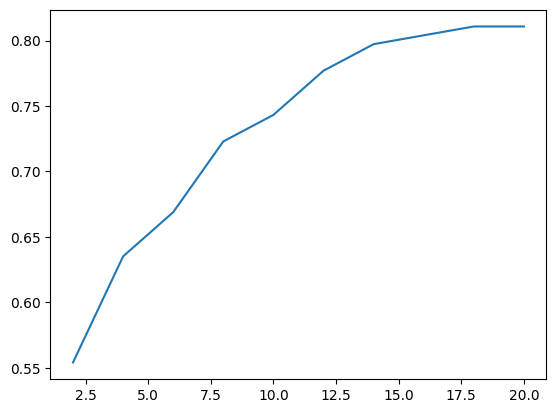

In [188]:
plt.plot(top_list, acc_list)